In [17]:
import os.path


class STLTemporalIntegration:
    """
    A class for implementing Seasonal-Trend decomposition with Temporal Integration
    for business KPI analysis.
    """

    def __init__(self, data, date_column, value_column, period=None):
        """
        Initialize with time series data.

        Parameters:
        -----------
        data : pandas DataFrame
            DataFrame containing the time series data
        date_column : str
            Name of the column containing datetime values
        value_column : str
            Name of the column containing KPI values
        period : int, optional
            The seasonal period (e.g., 7 for weekly, 12 for monthly, 365 for annual)
            If None, it will be inferred from the data frequency
        """
        self.df = data.copy()
        self.date_col = date_column
        self.value_col = value_column

        # Ensure date column is datetime type
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        # Sort by date
        self.df = self.df.sort_values(by=self.date_col).reset_index(drop=True)

        # Set date as index
        self.df.set_index(self.date_col, inplace=True)

        # Infer frequency if period is not provided
        if period is None:
            # Try to infer frequency from data
            freq = pd.infer_freq(self.df.index)
            if freq == 'D':
                self.period = 7  # Daily data, weekly seasonality
            elif freq == 'B':
                self.period = 5  # Business days, weekly seasonality
            elif freq in ['M', 'MS']:
                self.period = 12  # Monthly data, annual seasonality
            elif freq in ['Q', 'QS']:
                self.period = 4  # Quarterly data, annual seasonality
            else:
                self.period = 7  # Default to weekly
                print(f"Warning: Could not infer seasonality period from frequency {freq}. Defaulting to 7.")
        else:
            self.period = period

        # Initialize decomposition components
        self.trend = None
        self.seasonal = None
        self.resid = None

        print(f"Initialized with {len(self.df)} observations and seasonal period of {self.period}")

    def decompose(self, seasonal_deg=1, trend_deg=1, low_pass_deg=1,
                  seasonal_jump=1, trend_jump=1, low_pass_jump=1,
                  robust=False):
        """
        Perform STL decomposition on the time series.

        Parameters:
        -----------
        seasonal_deg : int
            Degree of seasonal LOESS
        trend_deg : int
            Degree of trend LOESS
        low_pass_deg : int
            Degree of low-pass LOESS
        seasonal_jump : int
            Jump for seasonal LOESS
        trend_jump : int
            Jump for trend LOESS
        low_pass_jump : int
            Jump for low-pass LOESS
        robust : bool
            Whether to use robust fitting

        Returns:
        --------
        self : STLTemporalIntegration
            Returns self for method chaining
        """
        # Handle missing values if any
        if self.df[self.value_col].isnull().any():
            print("Warning: Missing values detected. Interpolating...")
            self.df[self.value_col] = self.df[self.value_col].interpolate(method='linear')

        # Perform STL decomposition
        stl = STL(self.df[self.value_col],
                  period=self.period,
                  seasonal_deg=seasonal_deg,
                  trend_deg=trend_deg,
                  low_pass_deg=low_pass_deg,
                  seasonal_jump=seasonal_jump,
                  trend_jump=trend_jump,
                  low_pass_jump=low_pass_jump,
                  robust=robust)

        result = stl.fit()

        # Store decomposition components
        self.trend = result.trend
        self.seasonal = result.seasonal
        self.resid = result.resid

        # Create DataFrame with decomposition results
        self.decomposition = pd.DataFrame({
            'original': self.df[self.value_col],
            'trend': self.trend,
            'seasonal': self.seasonal,
            'remainder': self.resid,
            'deseasonalized': self.df[self.value_col] - self.seasonal
        }, index=self.df.index)

        print(f"Decomposition completed. Components extracted: trend, seasonal, remainder")
        return self

    def validate_decomposition(self):
        """
        Validate the quality of the decomposition using statistical tests.

        Returns:
        --------
        dict
            Dictionary containing validation metrics
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Check if seasonal component captures expected pattern
        # Calculate autocorrelation of seasonal component at seasonal lag
        seasonal_autocorr = self.seasonal.autocorr(lag=self.period)

        # Check for remaining seasonality in the residuals
        resid_autocorr = self.resid.autocorr(lag=self.period)

        # Check for correlation between components (should be low)
        trend_seasonal_corr, _ = pearsonr(self.trend, self.seasonal)
        trend_resid_corr, _ = pearsonr(self.trend, self.resid)
        seasonal_resid_corr, _ = pearsonr(self.seasonal, self.resid)

        # Verify conservation of mean (Lemma 1)
        original_mean = self.df[self.value_col].mean()
        trend_mean = self.trend.mean()
        mean_diff_pct = abs(original_mean - trend_mean) / original_mean * 100

        # Return validation metrics
        validation = {
            'seasonal_autocorrelation': seasonal_autocorr,
            'residual_seasonal_autocorrelation': resid_autocorr,
            'trend_seasonal_correlation': trend_seasonal_corr,
            'trend_residual_correlation': trend_resid_corr,
            'seasonal_residual_correlation': seasonal_resid_corr,
            'original_mean': original_mean,
            'trend_mean': trend_mean,
            'mean_difference_pct': mean_diff_pct
        }

        # Print validation summary
        print("\nDecomposition Validation:")
        print(f"Seasonal autocorrelation: {seasonal_autocorr:.4f} (should be high)")
        print(f"Residual seasonal autocorrelation: {resid_autocorr:.4f} (should be close to 0)")
        print(f"Trend-Seasonal correlation: {trend_seasonal_corr:.4f} (should be close to 0)")
        print(f"Trend-Residual correlation: {trend_resid_corr:.4f} (should be close to 0)")
        print(f"Seasonal-Residual correlation: {seasonal_resid_corr:.4f} (should be close to 0)")
        print(f"Original mean: {original_mean:.4f}")
        print(f"Trend mean: {trend_mean:.4f}")
        print(f"Mean difference: {mean_diff_pct:.2f}% (should be close to 0)")

        return validation

    def temporal_integration(self, start_date=None, end_date=None, component='trend',
                            weighted=False, lambda_weight=0.1, normalize=False):
        """
        Calculate temporal integration over a specified time interval.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for integration. If None, uses the first date.
        end_date : datetime or str, optional
            End date for integration. If None, uses the last date.
        component : str, optional
            Component to integrate: 'trend', 'original', 'deseasonalized'
        weighted : bool, optional
            Whether to apply exponential weighting
        lambda_weight : float, optional
            Rate parameter for exponential weighting
        normalize : bool, optional
            Whether to normalize by time interval length

        Returns:
        --------
        float
            The temporal integration value
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask]

        if len(subset) == 0:
            raise ValueError(f"No data found between {start_date} and {end_date}")

        # Select component to integrate
        if component == 'trend':
            values = subset['trend']
        elif component == 'original':
            values = subset['original']
        elif component == 'deseasonalized':
            values = subset['deseasonalized']
        else:
            raise ValueError(f"Unknown component: {component}")

        # Calculate time differences in days
        time_deltas = [(t - subset.index[0]).total_seconds() / (24*3600)
                       for t in subset.index]

        # Apply weighting if requested
        if weighted:
            # Calculate exponential weights
            max_time = time_deltas[-1]
            weights = np.exp(lambda_weight * (np.array(time_deltas) - max_time))
            weighted_values = values * weights

            # Perform numerical integration using trapezoidal rule
            integration = integrate.trapezoid(weighted_values, time_deltas)
        else:
            # Perform numerical integration using trapezoidal rule
            integration = integrate.trapezoid(values, time_deltas)

        # Normalize if requested
        if normalize:
            time_span = time_deltas[-1]
            integration = integration / time_span

        return integration

    def compare_integrations(self, intervals, component='trend', weighted=False,
                           lambda_weight=0.1, normalize=True):
        """
        Compare temporal integrations across multiple time intervals.

        Parameters:
        -----------
        intervals : list of tuples
            List of (start_date, end_date, label) tuples defining intervals
        component : str, optional
            Component to integrate
        weighted : bool, optional
            Whether to apply exponential weighting
        lambda_weight : float, optional
            Rate parameter for exponential weighting
        normalize : bool, optional
            Whether to normalize by time interval length

        Returns:
        --------
        pandas DataFrame
            DataFrame with integration results for each interval
        """
        results = []

        for start_date, end_date, label in intervals:
            # Calculate integrations for different components
            trend_integration = self.temporal_integration(
                start_date, end_date, 'trend', weighted, lambda_weight, normalize)

            original_integration = self.temporal_integration(
                start_date, end_date, 'original', weighted, lambda_weight, normalize)

            deseasonalized_integration = self.temporal_integration(
                start_date, end_date, 'deseasonalized', weighted, lambda_weight, normalize)

            # Calculate time span in days
            start = pd.to_datetime(start_date)
            end = pd.to_datetime(end_date)
            span_days = (end - start).total_seconds() / (24*3600)

            results.append({
                'interval': label,
                'start_date': start,
                'end_date': end,
                'span_days': span_days,
                'trend_integration': trend_integration,
                'original_integration': original_integration,
                'deseasonalized_integration': deseasonalized_integration,
                'trend_vs_original_diff_pct': (trend_integration - original_integration) / original_integration * 100 if original_integration != 0 else np.nan
            })

        return pd.DataFrame(results)

    def plot_decomposition(self, start_date=None, end_date=None, figsize=(15, 12)):
        """
        Plot the original series and its decomposition components.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for plotting
        end_date : datetime or str, optional
            End date for plotting
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plots
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask]

        # Create figure with subplots
        fig, axes = plt.subplots(5, 1, figsize=figsize, sharex=True)

        # Plot original series
        subset['original'].plot(ax=axes[0], color='blue')
        axes[0].set_title('Original Time Series')
        axes[0].grid(True)

        # Plot trend component
        subset['trend'].plot(ax=axes[1], color='red')
        axes[1].set_title('Trend Component')
        axes[1].grid(True)

        # Plot seasonal component
        subset['seasonal'].plot(ax=axes[2], color='green')
        axes[2].set_title('Seasonal Component')
        axes[2].grid(True)

        # Plot remainder component
        subset['remainder'].plot(ax=axes[3], color='purple')
        axes[3].set_title('Remainder Component')
        axes[3].grid(True)

        # Plot deseasonalized series
        subset['deseasonalized'].plot(ax=axes[4], color='orange')
        subset['trend'].plot(ax=axes[4], color='red', linestyle='--')
        axes[4].set_title('Deseasonalized Series vs Trend')
        axes[4].grid(True)
        axes[4].legend(['Deseasonalized', 'Trend'])

        # Format x-axis
        for ax in axes:
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
            ax.xaxis.set_major_locator(mdates.AutoDateLocator())

        plt.tight_layout()
        plt.xticks(rotation=45)

        return fig

    def plot_trend_integration(self, start_date=None, end_date=None, figsize=(15, 6)):
        """
        Visualize the trend integration as the area under the curve.

        Parameters:
        -----------
        start_date : datetime or str, optional
            Start date for integration visualization
        end_date : datetime or str, optional
            End date for integration visualization
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plot
        """
        if self.trend is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Set default dates if not provided
        if start_date is None:
            start_date = self.df.index.min()
        else:
            start_date = pd.to_datetime(start_date)

        if end_date is None:
            end_date = self.df.index.max()
        else:
            end_date = pd.to_datetime(end_date)

        # Get data for the specified time interval
        mask = (self.decomposition.index >= start_date) & (self.decomposition.index <= end_date)
        subset = self.decomposition[mask].copy()

        # Calculate integration value
        integration_value = self.temporal_integration(
            start_date, end_date, component='trend', normalize=False)
        normalized_integration = self.temporal_integration(
            start_date, end_date, component='trend', normalize=True)

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Plot trend component
        ax.plot(subset.index, subset['trend'], color='red', linewidth=2)

        # Fill area under the curve
        ax.fill_between(subset.index, subset['trend'], alpha=0.3, color='red')

        # Add horizontal line at y=0
        ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)

        # Add annotations
        ax.set_title(f'Trend Component Integration (Area Under the Curve)')
        ax.set_xlabel('Date')
        ax.set_ylabel('Trend Value')
        ax.grid(True)

        # Add integration value as text
        span_days = (end_date - start_date).total_seconds() / (24*3600)
        ax.text(0.02, 0.95,
                f'Time Period: {start_date.strftime("%Y-%m-%d")} to {end_date.strftime("%Y-%m-%d")}\n'
                f'Duration: {span_days:.1f} days\n'
                f'Total Integration: {integration_value:.2f}\n'
                f'Normalized Integration: {normalized_integration:.2f}',
                transform=ax.transAxes,
                bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=0.5'),
                fontsize=10, verticalalignment='top')

        plt.tight_layout()

        return fig

    def plot_comparative_integrations(self, result_df, figsize=(12, 6)):
        """
        Plot comparison of integrations across different intervals.

        Parameters:
        -----------
        result_df : pandas DataFrame
            Results from compare_integrations method
        figsize : tuple, optional
            Figure size

        Returns:
        --------
        matplotlib figure
            The figure containing the plot
        """
        # Create figure
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)

        # Plot comparison of trend vs original integrations
        barwidth = 0.35
        x = np.arange(len(result_df))

        ax1.bar(x - barwidth/2, result_df['trend_integration'], width=barwidth,
               label='Trend Integration', color='red', alpha=0.7)
        ax1.bar(x + barwidth/2, result_df['original_integration'], width=barwidth,
               label='Original Integration', color='blue', alpha=0.7)

        ax1.set_xlabel('Interval')
        ax1.set_ylabel('Integration Value')
        ax1.set_title('Comparison of Integration Methods')
        ax1.set_xticks(x)
        ax1.set_xticklabels(result_df['interval'], rotation=45)
        ax1.legend()
        ax1.grid(True, alpha=0.3)

        # Add percentage difference labels
        for i, row in enumerate(result_df.itertuples()):
            diff_pct = row.trend_vs_original_diff_pct
            if not np.isnan(diff_pct):
                color = 'green' if abs(diff_pct) < 10 else 'red'
                ax1.text(i, max(row.trend_integration, row.original_integration) + 0.5,
                       f"{diff_pct:.1f}%", ha='center', color=color, fontweight='bold')

        # Plot normalized trend integrations
        sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
                   palette='Reds_r')
        ax2.set_xlabel('Interval')
        ax2.set_ylabel('Normalized Trend Integration')
        ax2.set_title('Normalized Trend Integration by Interval')
        ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
        ax2.grid(True, alpha=0.3)

        # Add span days as text
        for i, row in enumerate(result_df.itertuples()):
            ax2.text(i, row.trend_integration/2,
                   f"{row.span_days:.0f} days", ha='center', color='white', fontweight='bold')

        plt.tight_layout()

        return fig


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import STL
from scipy import integrate
from scipy.stats import pearsonr
import seaborn as sns


def generate_synthetic_kpi_data(start_date='2024-01-01', periods=365, freq='D',
                               trend_factor=0.05, seasonal_amplitude=10,
                               seasonal_period=7, noise_level=2,
                               event_impacts=None):
    """
    Generate synthetic business KPI data with trend, seasonality, and random events.

    Parameters:
    -----------
    start_date : str
        Start date for the time series
    periods : int
        Number of periods to generate
    freq : str
        Frequency of the data ('D' for daily, 'W' for weekly, etc.)
    trend_factor : float
        Slope of the linear trend component
    seasonal_amplitude : float
        Amplitude of the seasonal component
    seasonal_period : int
        Period of the seasonal component
    noise_level : float
        Standard deviation of the noise component
    event_impacts : dict, optional
        Dictionary mapping dates to impact values for special events

    Returns:
    --------
    pandas DataFrame
        DataFrame containing the synthetic KPI data
    """
    # Generate date range
    dates = pd.date_range(start=start_date, periods=periods, freq=freq)

    # Generate linear trend
    trend = np.arange(periods) * trend_factor

    # Generate seasonal component
    seasonal = seasonal_amplitude * np.sin(2 * np.pi * np.arange(periods) / seasonal_period)

    # Generate noise component
    noise = np.random.normal(0, noise_level, periods)

    # Combine components
    kpi = trend + seasonal + noise

    # Add event impacts if provided
    if event_impacts:
        for date, impact in event_impacts.items():
            if date in dates:
                idx = dates.get_loc(date)
                kpi[idx] += impact

                # Add decay effect for a few days after the event
                decay_days = 5
                for i in range(1, decay_days + 1):
                    if idx + i < len(kpi):
                        kpi[idx + i] += impact * (1 - i/decay_days)

    # Create DataFrame
    df = pd.DataFrame({
        'date': dates,
        'kpi_value': kpi
    })

    return df

In [19]:
# Example usage with synthetic data
def demonstrate_with_synthetic_data():
    # Generate synthetic daily sales data with weekly seasonality
    # and monthly promotional events

    # Define event impacts (e.g., marketing campaigns, promotions)
    events = {
        '2022-02-15': 15,  # Valentine's Day promotion
        '2022-04-15': 20,  # Easter promotion
        '2022-07-04': 25,  # Independence Day event
        '2022-11-25': 30,  # Black Friday sale
        '2022-12-15': 35   # Christmas promotion
    }

    # Generate data
    data = generate_synthetic_kpi_data(
        start_date='2022-01-01',
        periods=365,
        freq='D',
        trend_factor=0.1,            # Steady upward trend
        seasonal_amplitude=15,       # Strong weekly seasonality
        seasonal_period=7,           # Weekly pattern
        noise_level=5,               # Moderate noise
        event_impacts=events         # Special events
    )

    print("Generated synthetic daily sales data with weekly seasonality and special events")

    # Initialize and run the analysis
    stl_ti = STLTemporalIntegration(data, 'date', 'kpi_value', period=7)

    # Perform decomposition
    stl_ti.decompose(
        seasonal_deg=1,    # Linear seasonal fitting
        trend_deg=1,       # Linear trend fitting
        robust=True        # Use robust fitting to handle outliers
    )

    # Validate decomposition
    validation = stl_ti.validate_decomposition()

    # Plot decomposition
    fig1 = stl_ti.plot_decomposition()
    plt.savefig('stl_decomposition.png')

    # Define quarterly intervals for comparison
    quarterly_intervals = [
        ('2022-01-01', '2022-03-31', 'Q1'),
        ('2022-04-01', '2022-06-30', 'Q2'),
        ('2022-07-01', '2022-09-30', 'Q3'),
        ('2022-10-01', '2022-12-31', 'Q4')
    ]

    # Compare integrations across quarters
    quarterly_results = stl_ti.compare_integrations(
        quarterly_intervals,
        normalize=True      # Normalize by time period for fair comparison
    )

    print("\nQuarterly Temporal Integration Results:")
    print(quarterly_results[['interval', 'span_days', 'trend_integration',
                             'original_integration', 'trend_vs_original_diff_pct']])

    # Plot comparison
    fig2 = stl_ti.plot_comparative_integrations(quarterly_results)
    plt.savefig('quarterly_comparison.png')

    # Visualize trend integration for a specific period
    fig3 = stl_ti.plot_trend_integration('2022-07-01', '2022-09-30')
    plt.savefig('q3_trend_integration.png')

    # Compare high-season vs low-season
    seasonal_intervals = [
        ('2022-11-01', '2022-12-31', 'Holiday Season'),
        ('2022-02-01', '2022-03-31', 'Low Season')
    ]

    seasonal_results = stl_ti.compare_integrations(
        seasonal_intervals,
        normalize=True
    )

    print("\nSeasonal Comparison Results:")
    print(seasonal_results[['interval', 'span_days', 'trend_integration',
                           'original_integration', 'trend_vs_original_diff_pct']])

    # Plot seasonal comparison
    fig4 = stl_ti.plot_comparative_integrations(seasonal_results)
    plt.savefig('seasonal_comparison.png')

    return stl_ti, quarterly_results, seasonal_results

Generated synthetic daily sales data with weekly seasonality and special events
Initialized with 365 observations and seasonal period of 7
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9934 (should be high)
Residual seasonal autocorrelation: -0.1829 (should be close to 0)
Trend-Seasonal correlation: -0.0154 (should be close to 0)
Trend-Residual correlation: 0.1201 (should be close to 0)
Seasonal-Residual correlation: -0.0360 (should be close to 0)
Original mean: 18.9543
Trend mean: 18.3564
Mean difference: 3.15% (should be close to 0)

Quarterly Temporal Integration Results:
  interval  span_days  trend_integration  original_integration  \
0       Q1       89.0           5.286542              5.576035   
1       Q2       90.0          13.151445             13.905072   
2       Q3       91.0          22.904323             23.095012   
3       Q4       91.0          31.715200             33.192045   

   t

/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/

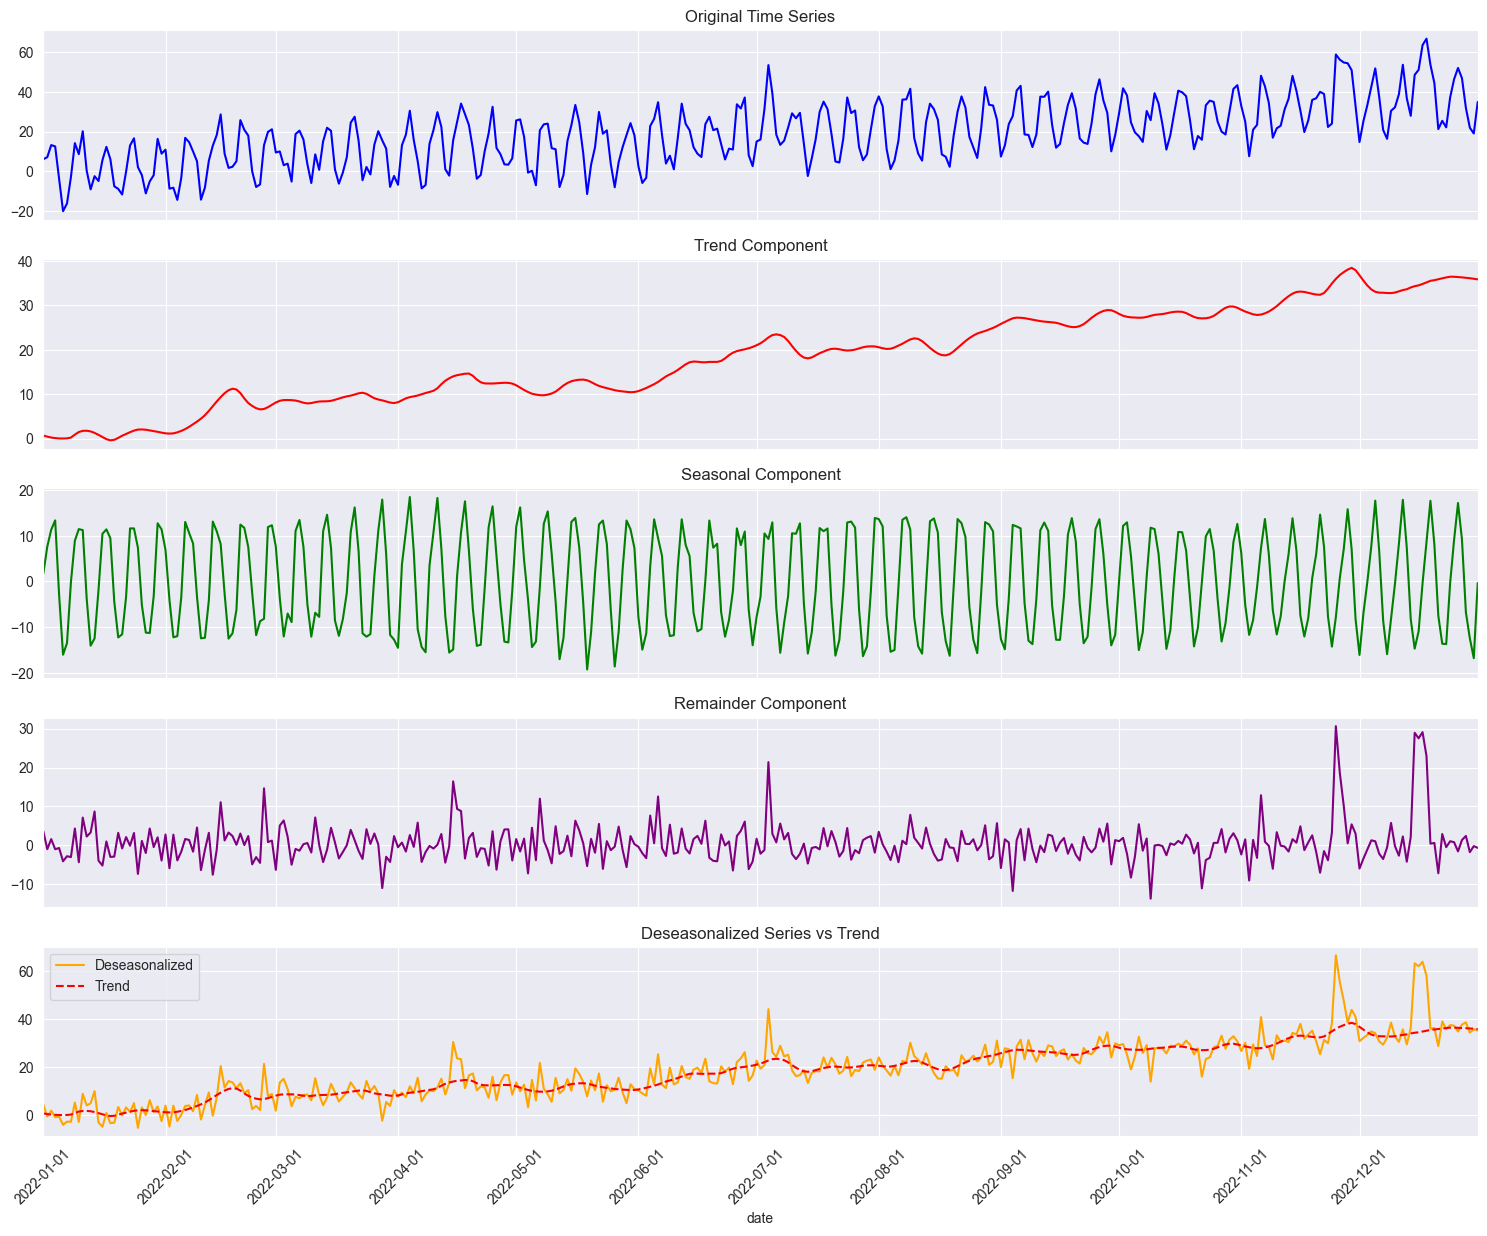

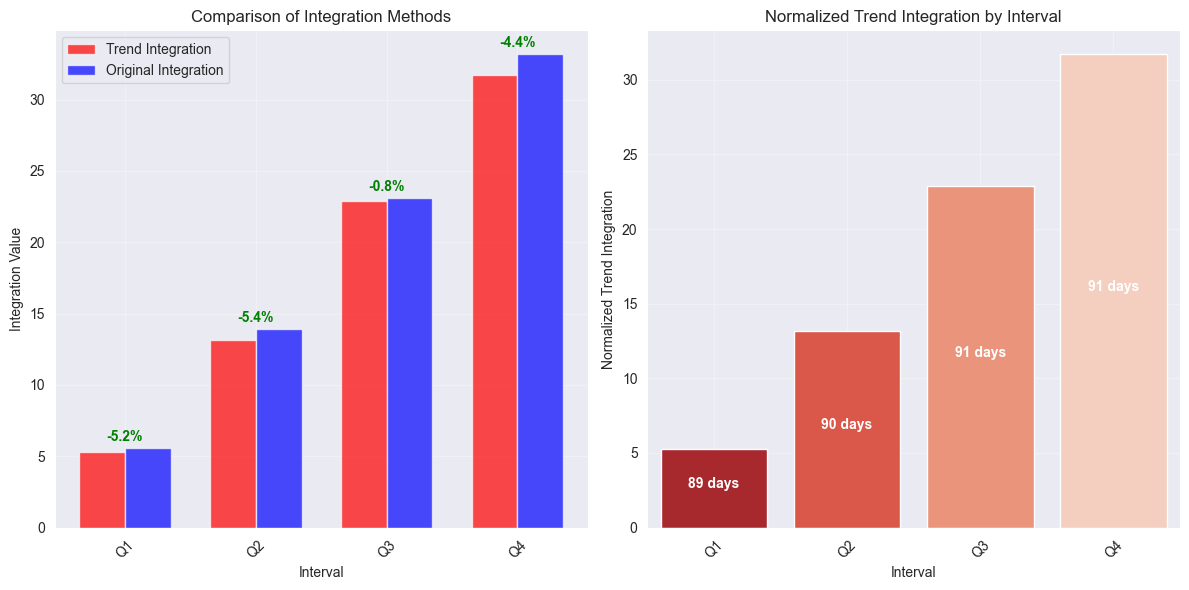

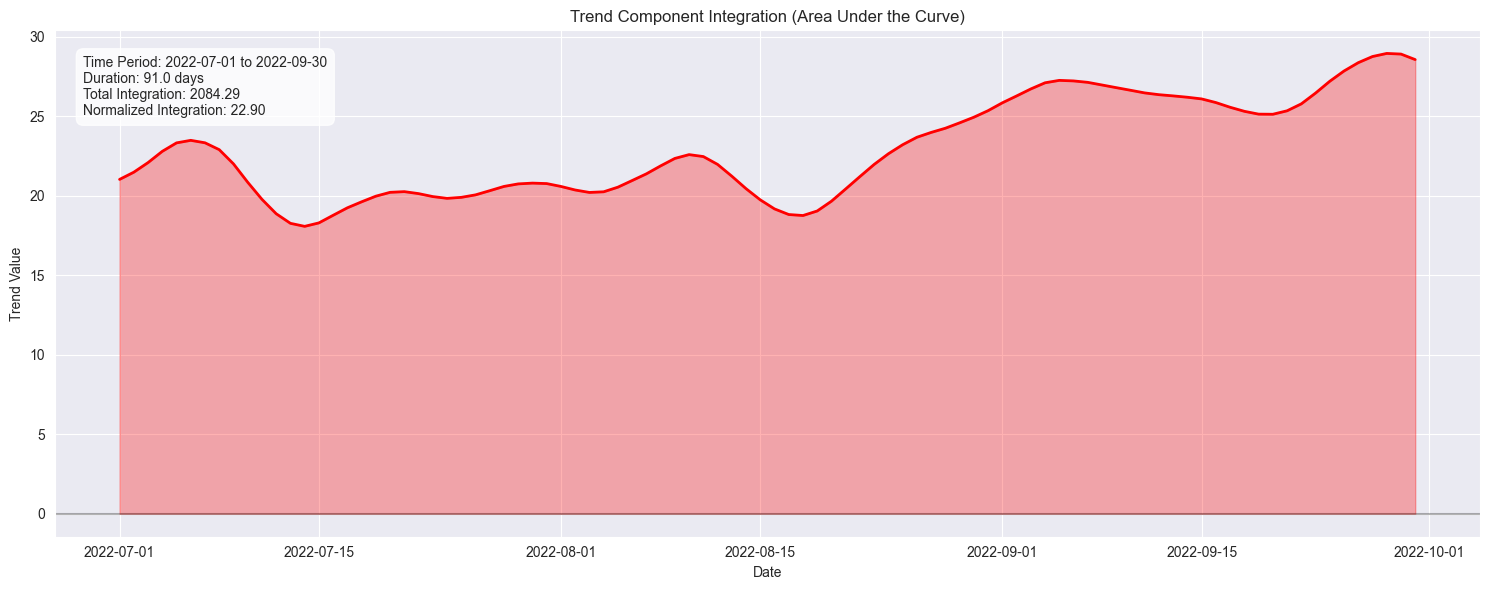

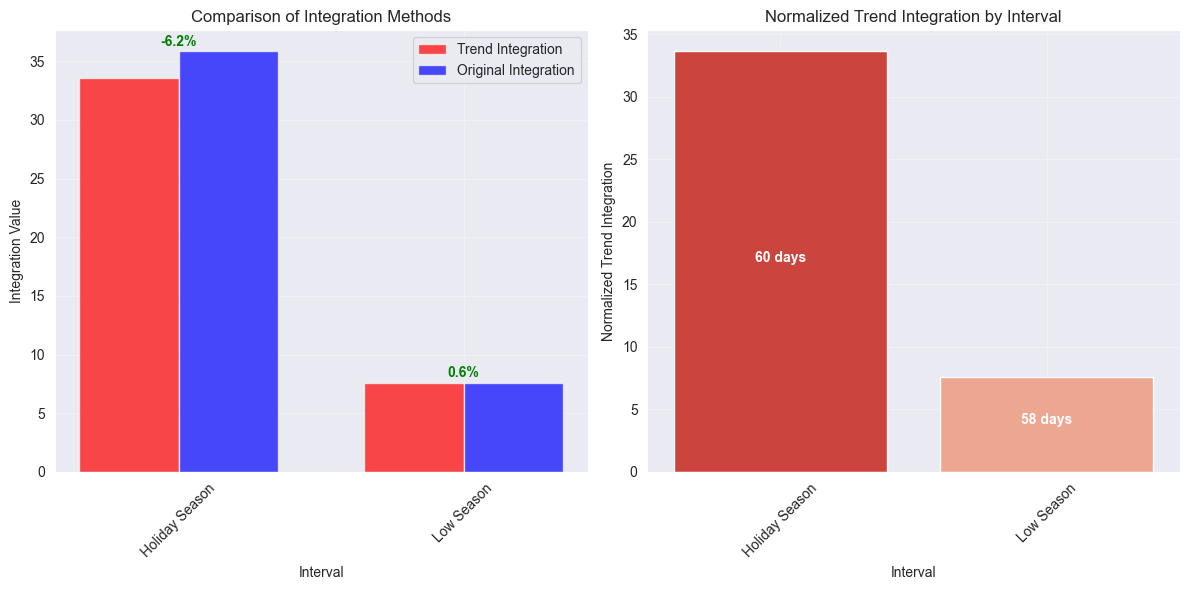

In [20]:
# Run demonstration with synthetic data
stl_ti, quarterly_results, seasonal_results = demonstrate_with_synthetic_data()

# Show all plots
plt.show()

# Input Data Requirements and Format
**Data Structure**

The implementation expects input data in the form of a pandas DataFrame with the following characteristics:

1.	Time Series Format: The data must contain at least two columns:
    - A date/time column with regular intervals (e.g., daily, weekly, monthly)
    - A numeric KPI value column
2.	Regular Time Intervals: The data should have observations at regular time intervals. While the code includes interpolation for missing values, consistent spacing produces the most reliable results.
3.	Sufficient History: For reliable seasonal decomposition, the data should span multiple seasonal cycles (e.g., several weeks for weekly seasonality, multiple years for annual seasonality).

```
        date  kpi_value
0 2022-01-01      45.2
1 2022-01-02      42.8
2 2022-01-03      48.7
3 2022-01-04      51.3
```


# Key Data Characteristics

For optimal results, the input data should exhibit:

1.	Clear Seasonal Pattern: The data should have identifiable seasonal patterns that repeat with consistent periodicity (e.g., weekly sales cycles, monthly billing patterns, quarterly reporting effects).
2.	Sufficient Length: The time series should contain at least 2-3 complete seasonal cycles to enable proper decomposition.
3.	Minimal Data Gaps: While the implementation handles missing values through interpolation, excessive gaps can compromise the quality of the decomposition.
4.	Trend Component: Ideally, the data should contain a meaningful trend component that represents the underlying direction of the KPI independent of seasonal fluctuations.
5.	Reasonable Noise Level: The data should have a signal-to-noise ratio that allows the decomposition to effectively separate components. Extremely noisy data may require additional preprocessing.

## Real-World KPI Examples

This methodology is suitable for various business KPIs exhibiting seasonality, such as:

1.	Retail Sales: Daily or weekly sales figures with day-of-week patterns and holiday effects
2.	Website Traffic: Hourly or daily visitor counts with day/night and weekday/weekend patterns
3.	Call Center Volume: Hourly or daily call counts with time-of-day and day-of-week patterns
4.	Manufacturing Output: Daily or weekly production figures with shift patterns and maintenance cycles
5.	Financial Metrics: Monthly revenue or profit figures with quarterly reporting cycles and annual seasonality
6.	Energy Consumption: Daily usage metrics with weather-related seasonality
7.	Customer Engagement: Weekly active user metrics with weekend/weekday patterns



## Validation Process and Code Explanation

The implementation validates the Seasonal-Trend Decomposition with Temporal Integration framework through several key steps:
1. Decomposition Validation
The `validate_decomposition()` method verifies the quality of the STL decomposition by checking:
	•	Seasonal Component Quality: High autocorrelation at the seasonal lag indicates effective capture of seasonal patterns
	•	Residual Quality: Low autocorrelation at the seasonal lag in the residuals confirms no remaining seasonality
	•	Component Independence: Low correlation between trend, seasonal, and residual components validates proper separation
	•	Conservation of Mean: Confirms that the trend component preserves the mean of the original series (Lemma 1)
2. Integration Comparison
The code implements multiple integration methods:
	•	Basic Temporal Integration: Direct application of the trapezoidal rule to the trend component
	•	Normalized Integration: Division by time interval length for comparable measures across periods
	•	Weighted Integration: Optional exponential weighting to emphasize recent observations
The `compare_integrations()` method quantifies the difference between trend integration and direct integration of the original series, demonstrating how seasonality can distort performance assessment when not properly accounted for.
3. Visualization
The implementation provides visualization functions that illustrate:
	•	The decomposition of the original series into trend, seasonal, and residual components
	•	The area under the curve representation of temporal integration
	•	Comparative analysis of integrations across different time periods
These visualizations help validate the theoretical properties discussed in the framework and demonstrate the practical benefits of the approach.

In [21]:

def run_analysis(data, year):
    stl_analysis = STLTemporalIntegration(
        data=data,
        date_column='date',
        value_column='kpi_value',
        period=12  # Monthly data with annual seasonality
    )

    # Perform decomposition
    stl_analysis.decompose(robust=True)
    # Validate decomposition
    validation_metrics = stl_analysis.validate_decomposition()
    # Define quarterly periods for comparison
    quarters = [
        (f'{year}-01-01', f'{year}-03-31', f'Q1 {year}'),
        (f'{year}-04-01', f'{year}-06-30', f'Q1 {year}'),
        (f'{year}-07-01', f'{year}-09-30', f'Q1 {year}'),
        (f'{year}-10-01', f'{year}-12-31', f'Q1 {year}'),
    ]

    # Compare temporal integrations
    results = stl_analysis.compare_integrations(quarters, normalize=True)

    # Visualize results
    stl_analysis.plot_decomposition()
    stl_analysis.plot_comparative_integrations(results)


Initialized with 132 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9413 (should be high)
Residual seasonal autocorrelation: -0.1949 (should be close to 0)
Trend-Seasonal correlation: -0.1624 (should be close to 0)
Trend-Residual correlation: 0.0089 (should be close to 0)
Seasonal-Residual correlation: -0.1607 (should be close to 0)
Original mean: 437457.2348
Trend mean: 438994.0464
Mean difference: 0.35% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


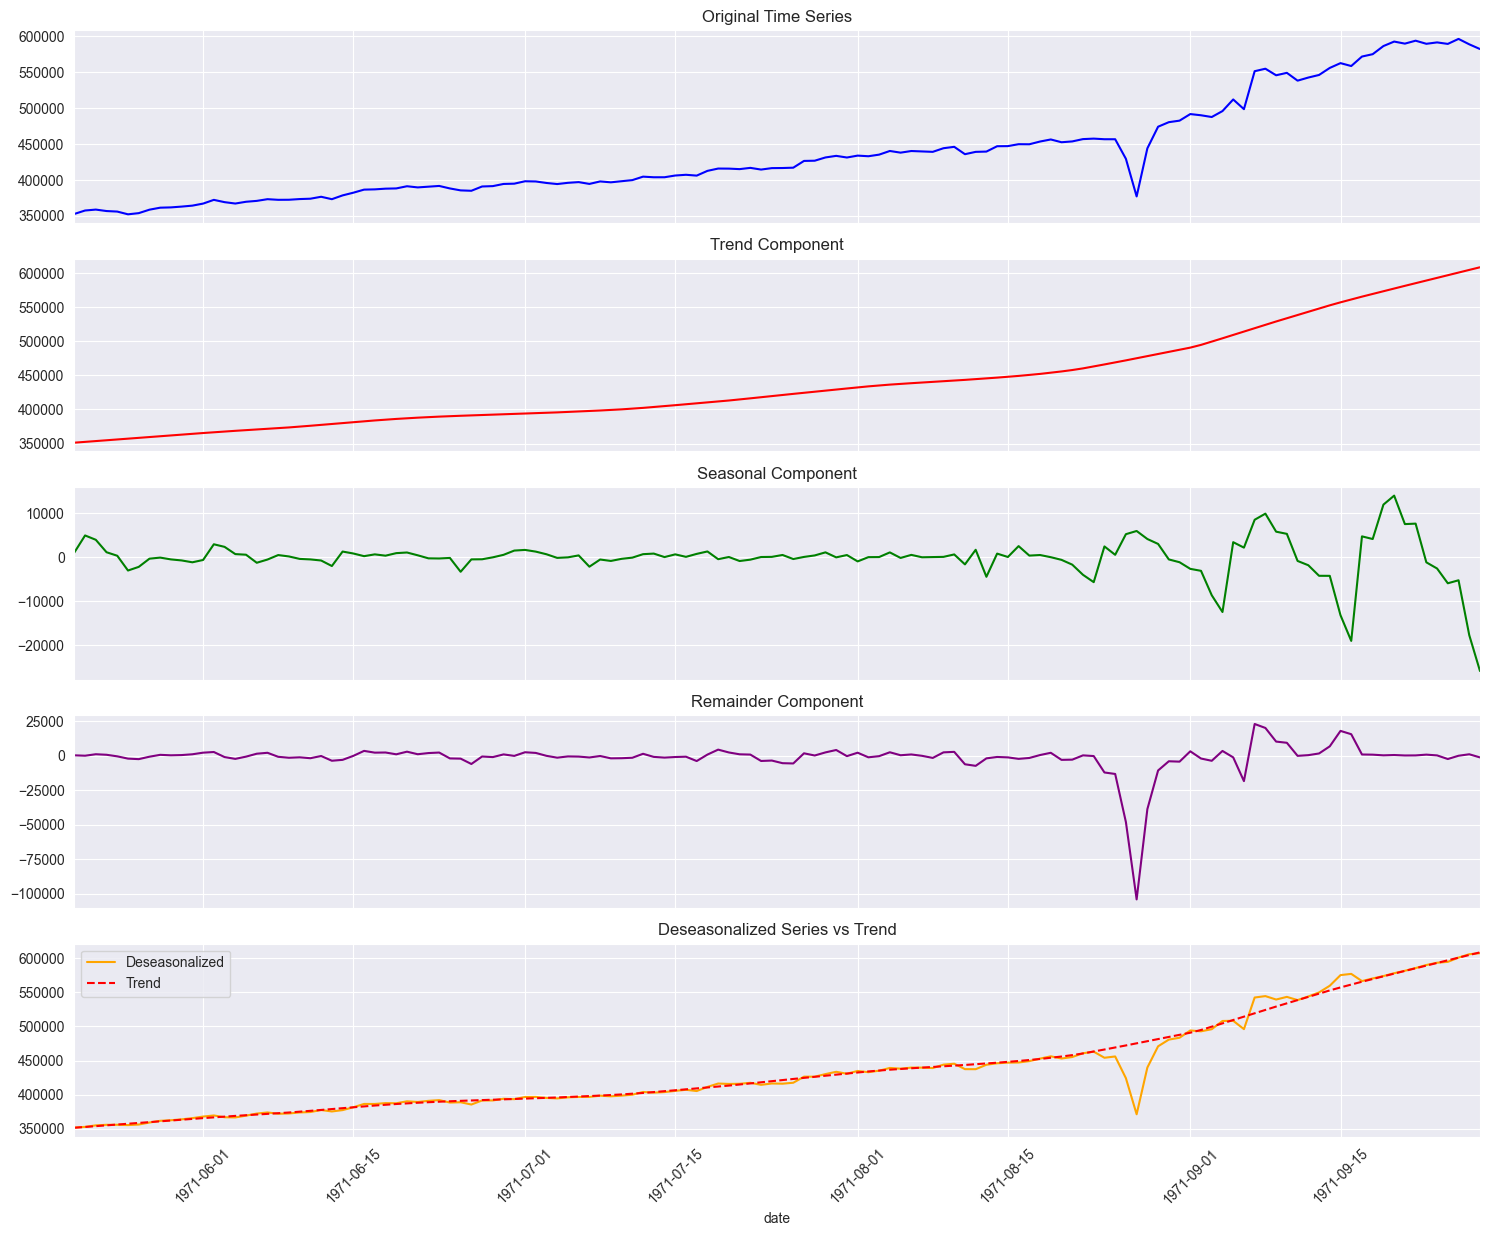

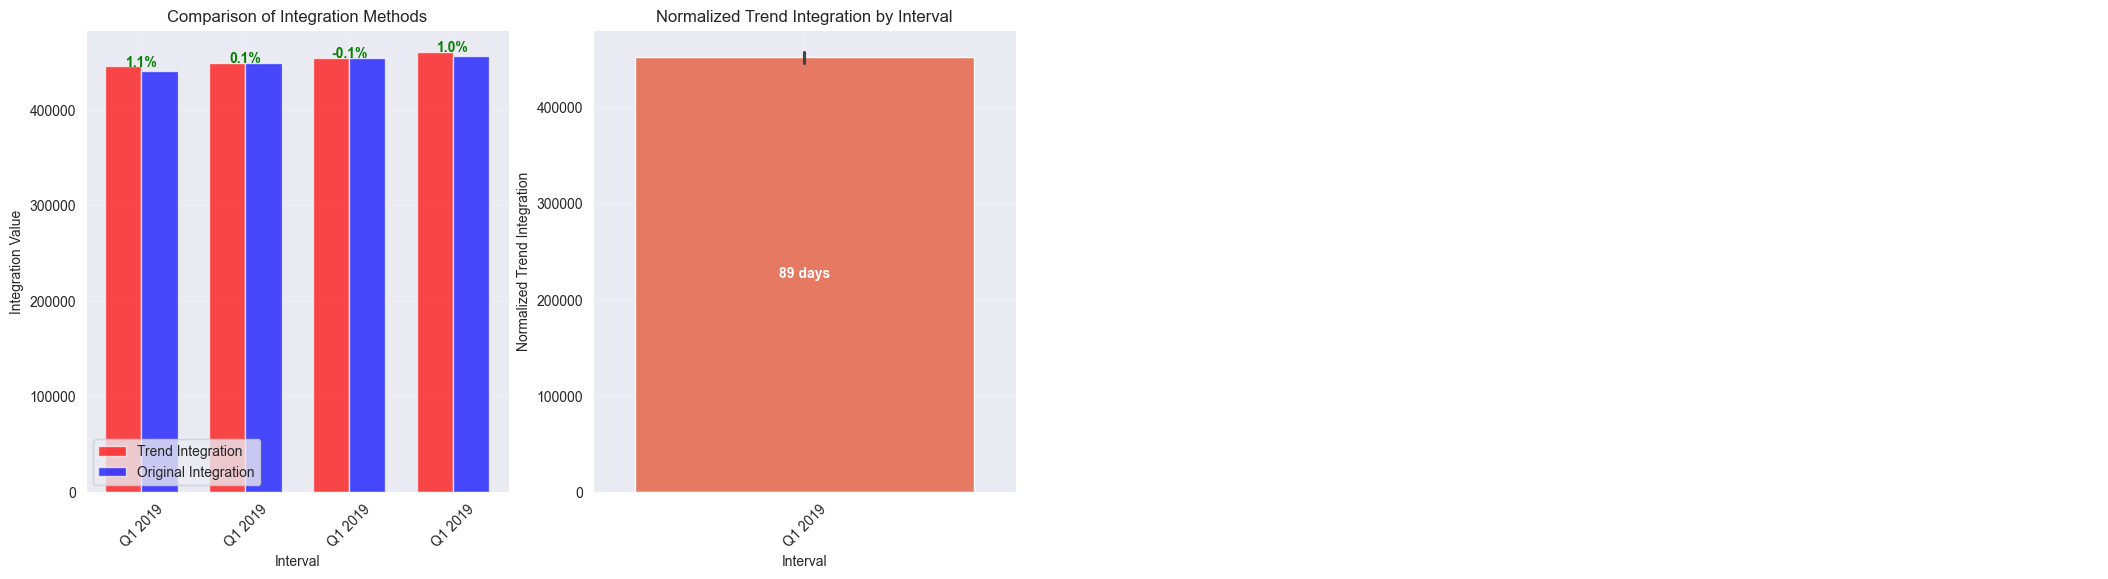

In [22]:
retail_sales_fred = pd.read_parquet('retail_sales_fred.parquet')
run_analysis(retail_sales_fred, 2019)

Initialized with 305 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.9351 (should be high)
Residual seasonal autocorrelation: -0.0459 (should be close to 0)
Trend-Seasonal correlation: 0.0085 (should be close to 0)
Trend-Residual correlation: 0.0126 (should be close to 0)
Seasonal-Residual correlation: -0.0946 (should be close to 0)
Original mean: 29217.7308
Trend mean: 26745.9433
Mean difference: 8.46% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


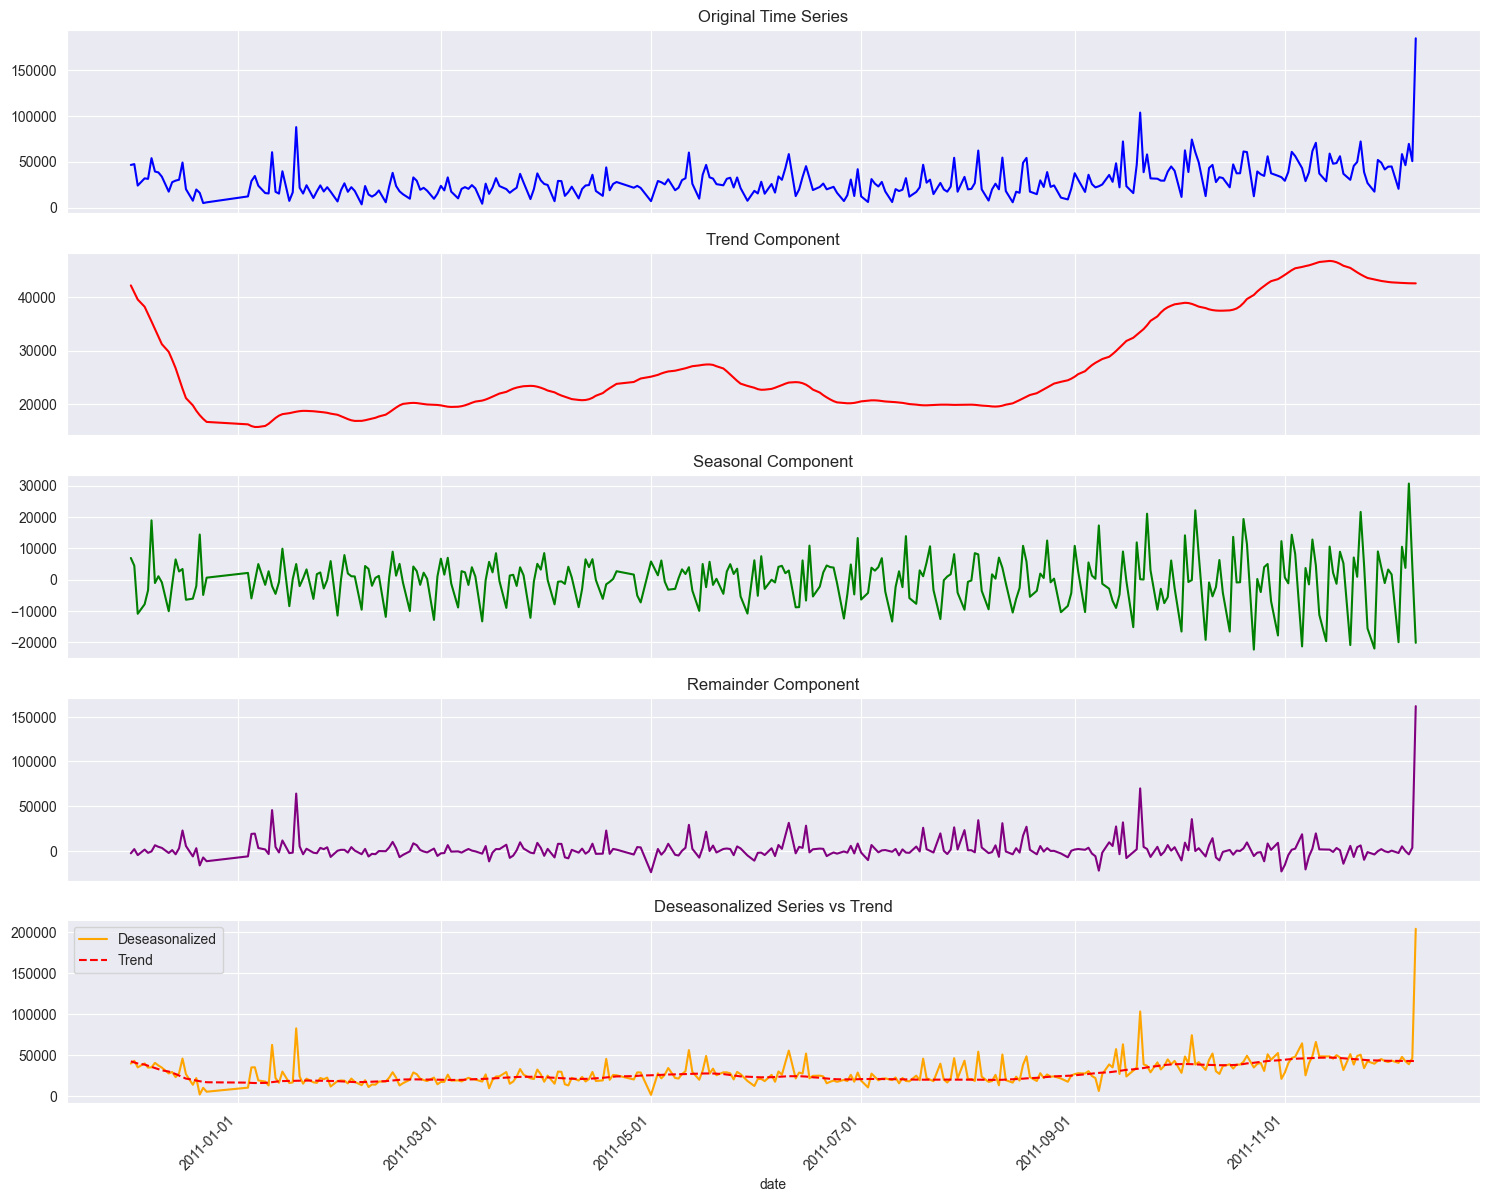

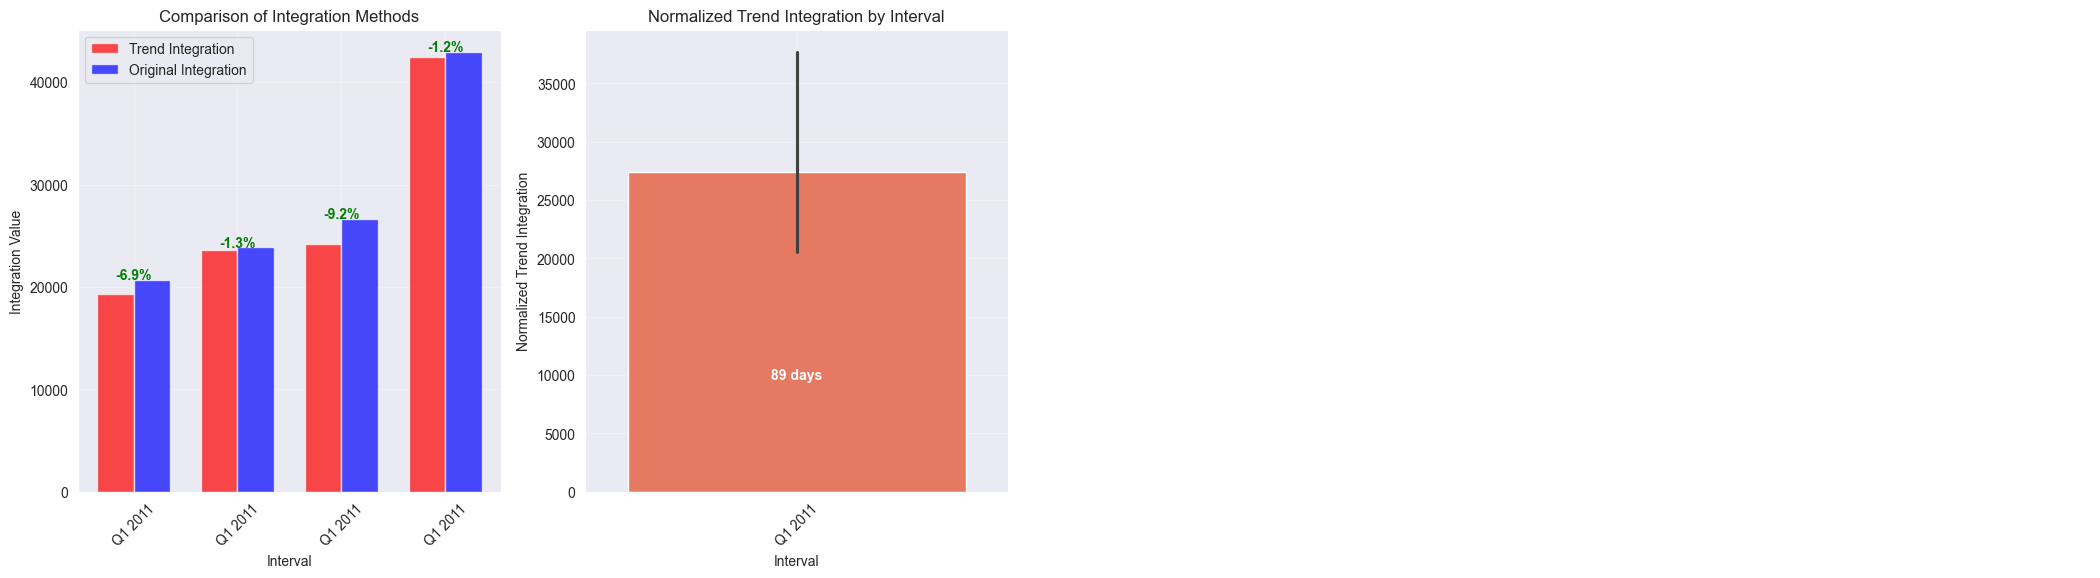

In [25]:
retail_sales_uci = pd.read_parquet('retail_sales_uci.parquet')
run_analysis(retail_sales_uci, 2011)

Initialized with 574 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.1162 (should be high)
Residual seasonal autocorrelation: -0.2044 (should be close to 0)
Trend-Seasonal correlation: -0.0279 (should be close to 0)
Trend-Residual correlation: 0.0952 (should be close to 0)
Seasonal-Residual correlation: -0.1207 (should be close to 0)
Original mean: 388768.2927
Trend mean: 376606.7238
Mean difference: 3.13% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


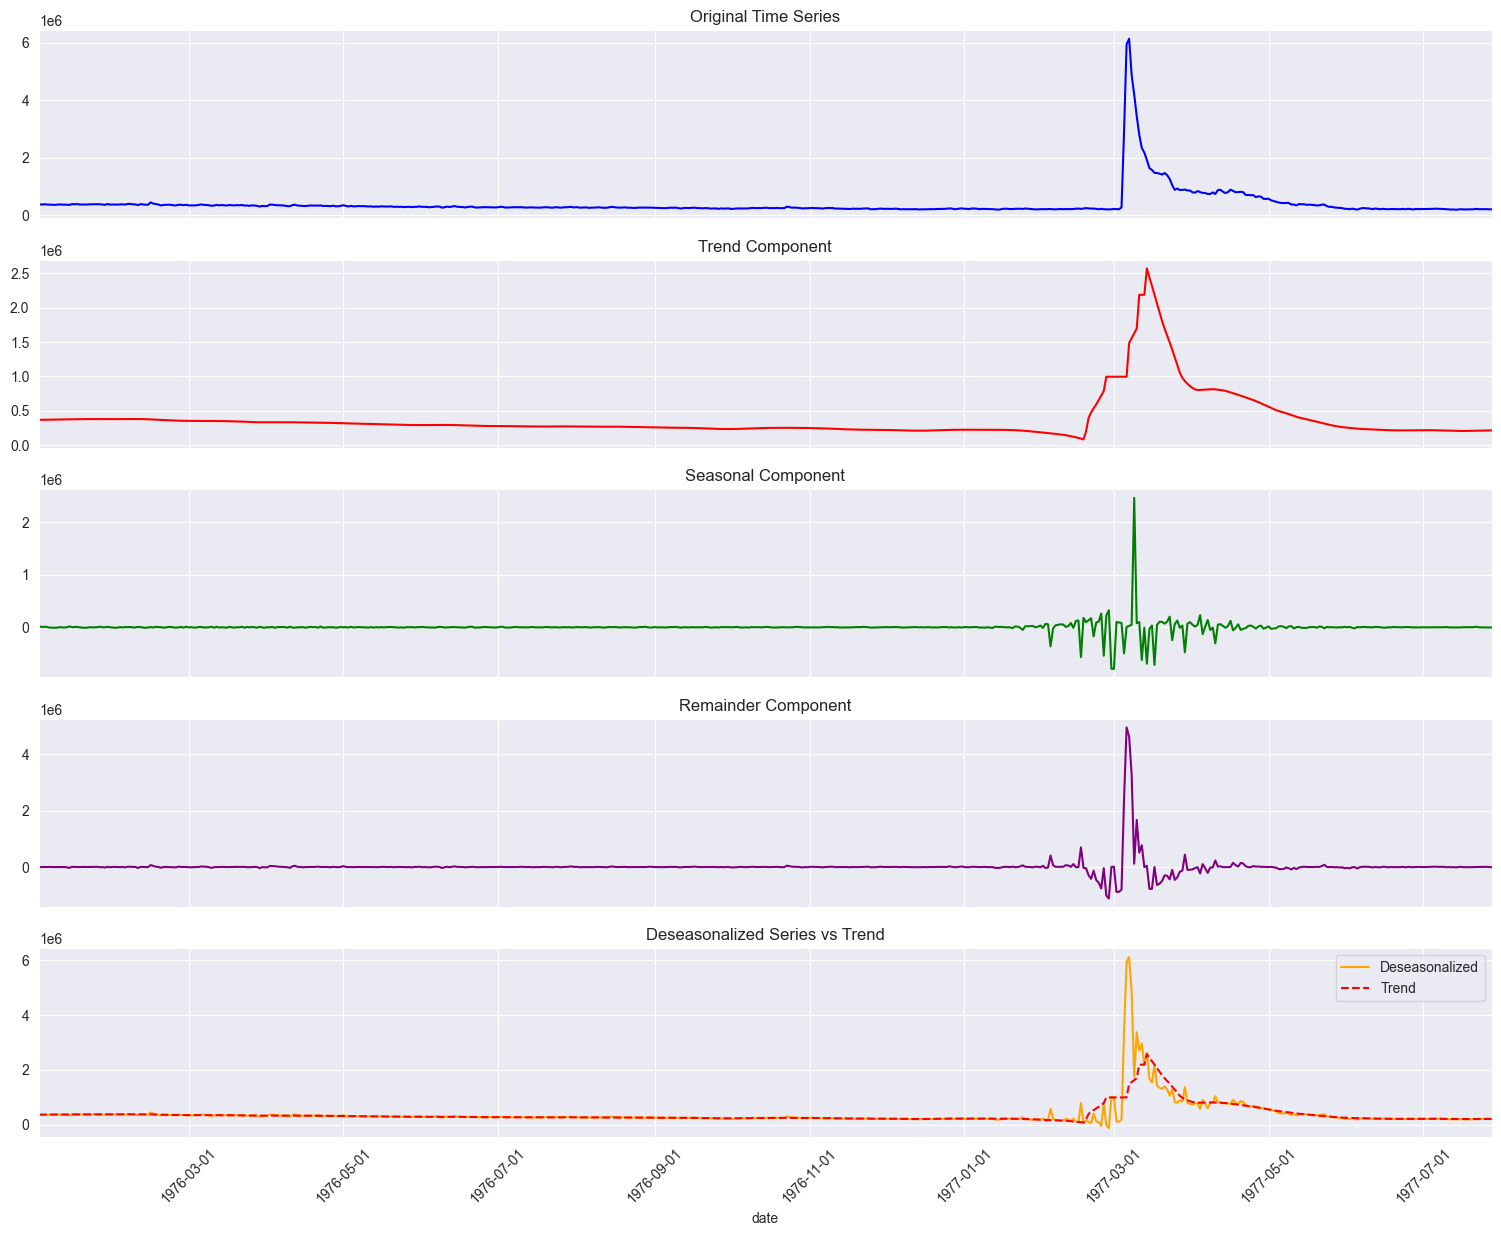

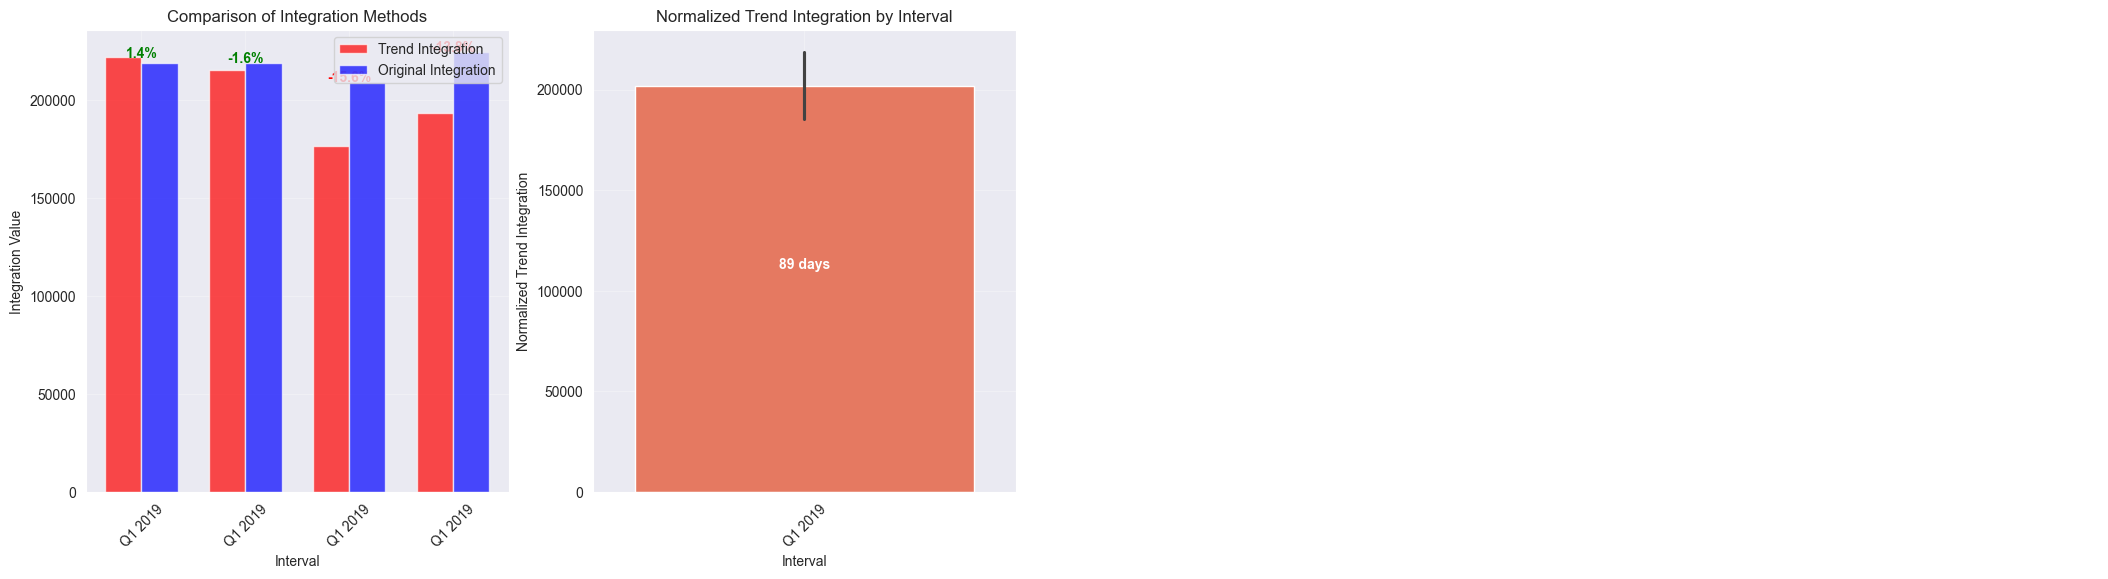

In [26]:
unemployment_claims = pd.read_parquet('unemployment_claims.parquet')
run_analysis(unemployment_claims, 2019)

Initialized with 366 observations and seasonal period of 12
Decomposition completed. Components extracted: trend, seasonal, remainder

Decomposition Validation:
Seasonal autocorrelation: 0.8520 (should be high)
Residual seasonal autocorrelation: -0.0613 (should be close to 0)
Trend-Seasonal correlation: -0.0300 (should be close to 0)
Trend-Residual correlation: -0.1139 (should be close to 0)
Seasonal-Residual correlation: -0.0843 (should be close to 0)
Original mean: 58420.2923
Trend mean: 57685.5010
Mean difference: 1.26% (should be close to 0)


/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:511: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='interval', y='trend_integration', data=result_df, ax=ax2,
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:516: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45)
/var/folders/12/1t4w1b4167720vj7krs7kgtr0000gn/T/ipykernel_5314/4037030876.py:524: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


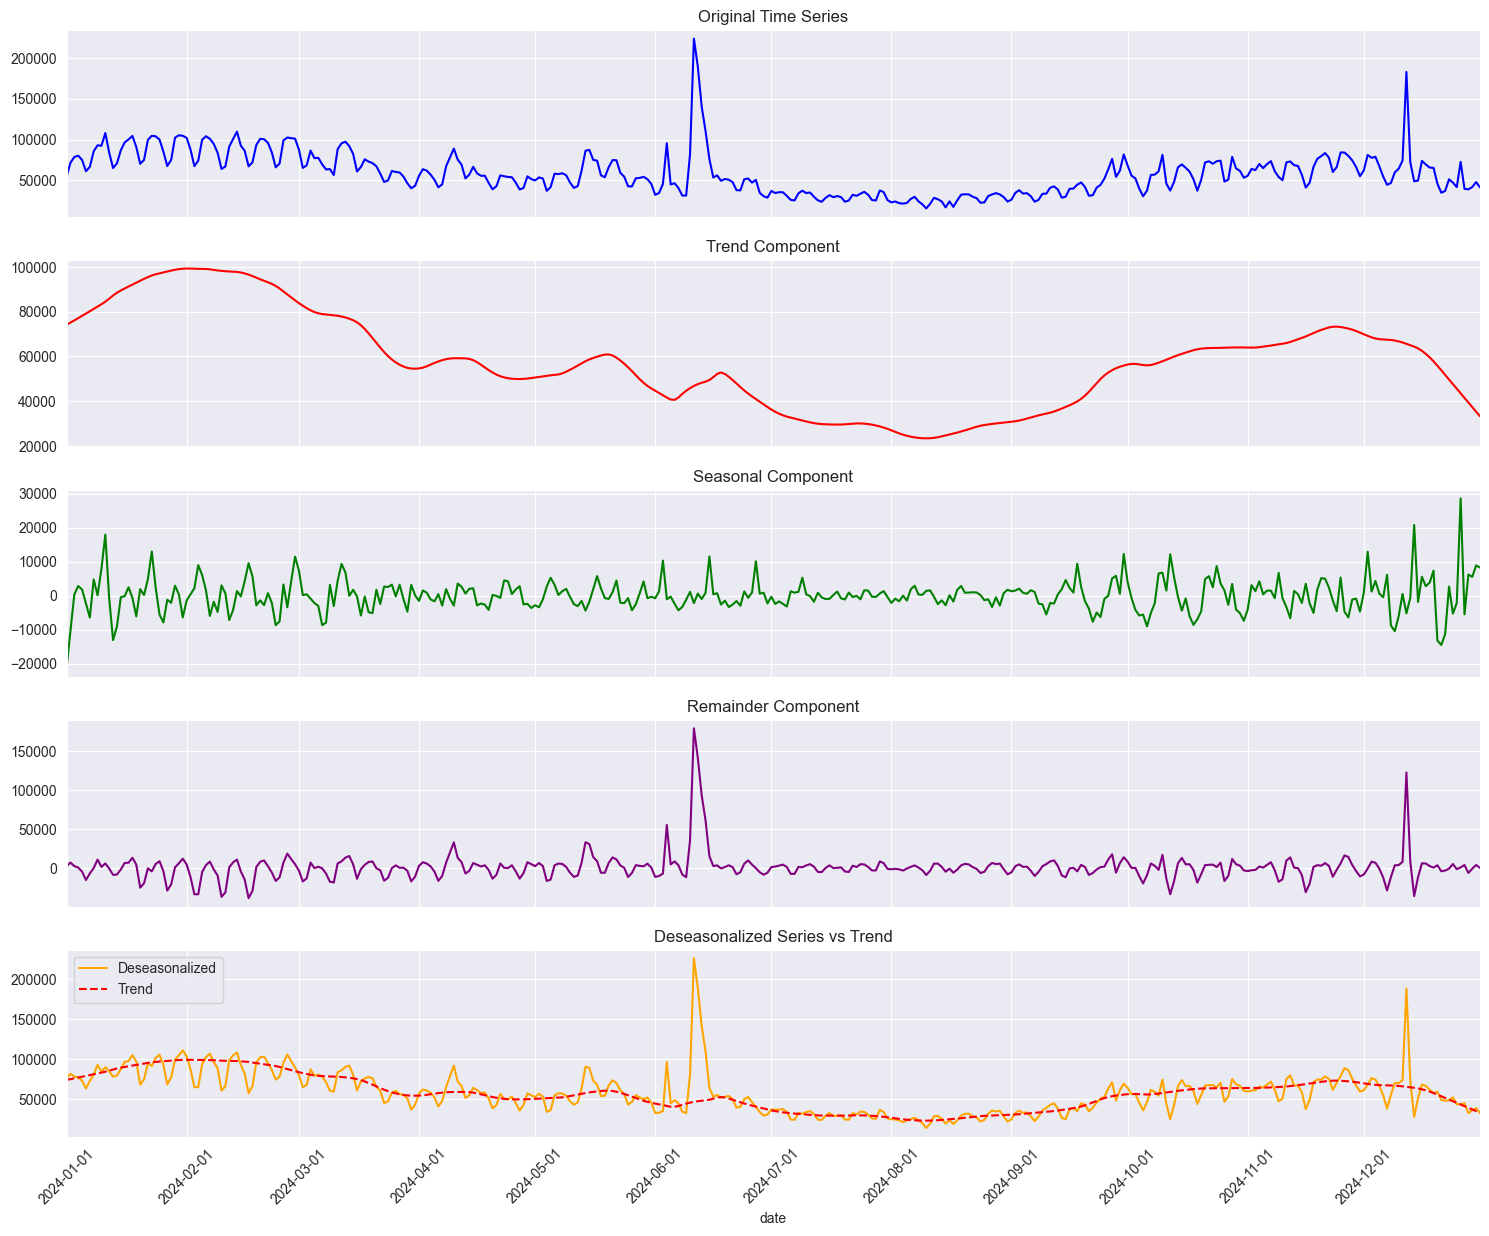

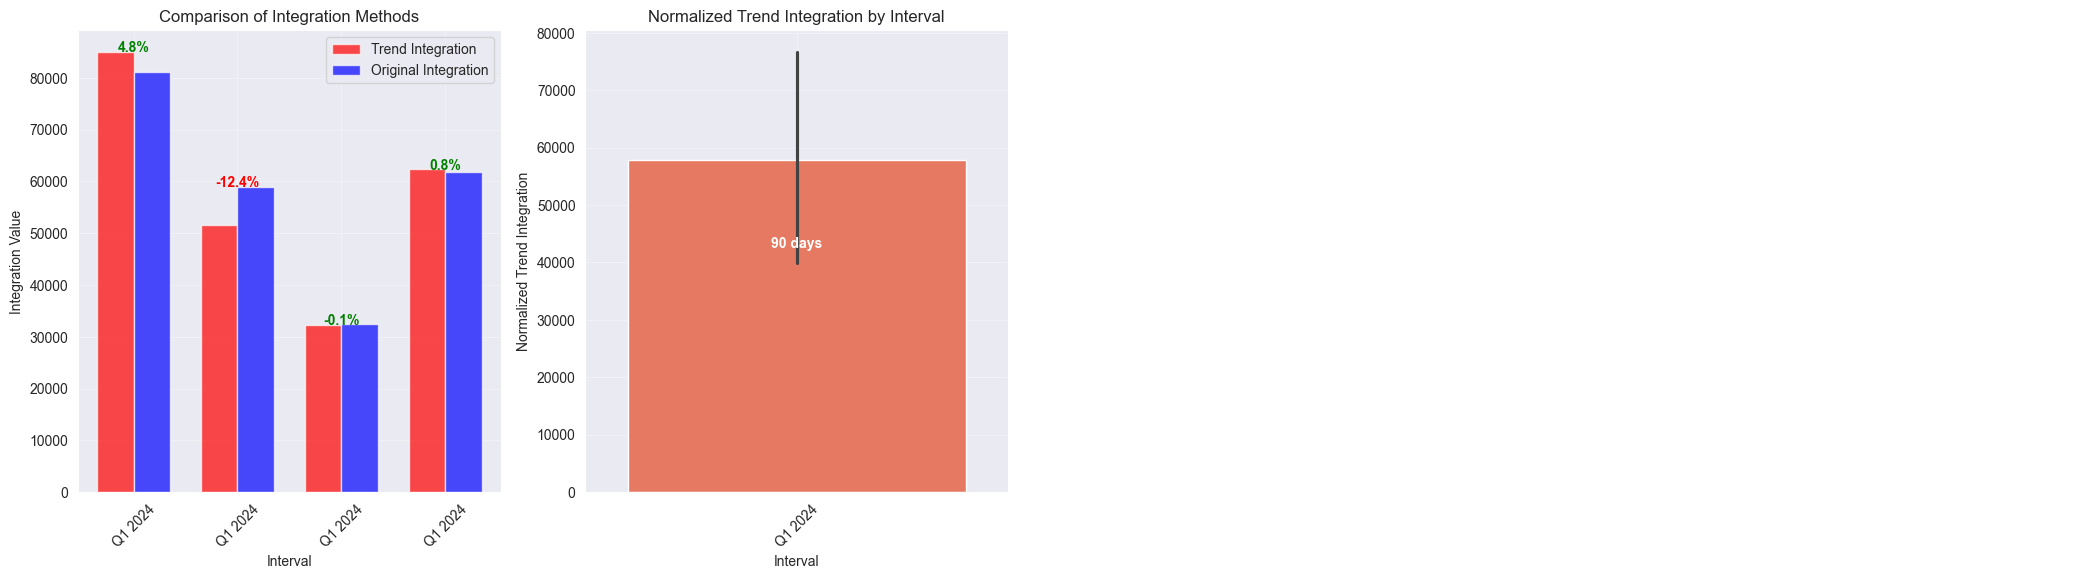

In [27]:
wiki_pageviews = pd.read_parquet('wikipedia_pageviews.parquet')
run_analysis(wiki_pageviews, 2024)

In [53]:
from scipy.stats import zscore
import networkx as nx
import warnings
warnings.filterwarnings("ignore")

class MTSN:
    """
    Multi-Layer Temporal-Seasonal Network (MTSN) for KPI analysis with hotspot detection.
    """

    def __init__(self, data=None, date_column=None, value_column=None, period=None,
                 hotspot_threshold=2.5, autocorr_threshold=0.3):
        """
        Initialize the MTSN framework.

        Parameters:
        -----------
        data : pandas DataFrame
            DataFrame containing time series data
        date_column : str
            Name of the column containing datetime values
        value_column : str
            Name of the column containing KPI values
        period : int
            The seasonal period (e.g., 7 for weekly, 12 for monthly)
        hotspot_threshold : float
            Z-score threshold for hotspot detection
        autocorr_threshold : float
            Threshold for significant seasonal autocorrelation
        """
        self.df = None
        self.date_col = date_column
        self.value_col = value_column
        self.period = period
        self.hotspot_threshold = hotspot_threshold
        self.autocorr_threshold = autocorr_threshold

        # Graph components
        self.G = None
        self.decomposition = None

        # Component series
        self.trend = None
        self.seasonal = None
        self.remainder = None

        # Hotspot information
        self.hotspots = None

        # If data is provided, load it
        if data is not None and date_column is not None and value_column is not None:
            self.load_data(data, date_column, value_column)

    def load_data(self, data, date_column, value_column):
        """
        Load time series data into the MTSN framework.

        Parameters:
        -----------
        data : pandas DataFrame
            DataFrame containing time series data
        date_column : str
            Name of the column containing datetime values
        value_column : str
            Name of the column containing KPI values
        """
        self.df = data.copy()
        self.date_col = date_column
        self.value_col = value_column

        # Ensure date column is datetime type
        self.df[self.date_col] = pd.to_datetime(self.df[self.date_col])

        # Sort by date
        self.df = self.df.sort_values(by=self.date_col).reset_index(drop=True)

        # Set date as index
        self.df.set_index(self.date_col, inplace=True)

        # Infer frequency if period is not provided
        if self.period is None:
            # Try to infer frequency from data
            freq = pd.infer_freq(self.df.index)
            if freq == 'D':
                self.period = 7  # Daily data, weekly seasonality
            elif freq == 'B':
                self.period = 5  # Business days, weekly seasonality
            elif freq in ['M', 'MS']:
                self.period = 12  # Monthly data, annual seasonality
            elif freq in ['Q', 'QS']:
                self.period = 4  # Quarterly data, annual seasonality
            else:
                self.period = 7  # Default to weekly
                print(f"Warning: Could not infer seasonality period from frequency. Defaulting to 7.")

        print(f"Loaded {len(self.df)} observations with seasonal period {self.period}")
        return self

    def decompose(self, seasonal_deg=1, trend_deg=1, low_pass_deg=1, robust=False):
        """
        Perform STL decomposition on the time series data.

        Parameters:
        -----------
        seasonal_deg : int
            Degree of seasonal LOESS
        trend_deg : int
            Degree of trend LOESS
        low_pass_deg : int
            Degree of low-pass LOESS
        robust : bool
            Whether to use robust fitting

        Returns:
        --------
        self : MTSN
            Returns self for method chaining
        """
        if self.df is None:
            raise ValueError("No data loaded. Call load_data() first.")

        # Handle missing values if any
        if self.df[self.value_col].isnull().any():
            print("Warning: Missing values detected. Interpolating...")
            self.df[self.value_col] = self.df[self.value_col].interpolate(method='linear')

        # Perform STL decomposition
        stl = STL(self.df[self.value_col],
                  period=self.period,
                  seasonal_deg=seasonal_deg,
                  trend_deg=trend_deg,
                  low_pass_deg=low_pass_deg,
                  robust=robust)

        result = stl.fit()

        # Store decomposition components
        self.trend = result.trend
        self.seasonal = result.seasonal
        self.remainder = result.resid

        # Create DataFrame with decomposition results
        self.decomposition = pd.DataFrame({
            'original': self.df[self.value_col],
            'trend': self.trend,
            'seasonal': self.seasonal,
            'remainder': self.remainder,
            'deseasonalized': self.df[self.value_col] - self.seasonal
        }, index=self.df.index)

        # Reset index to get date as a column
        self.decomposition = self.decomposition.reset_index()

        print(f"Decomposition completed.")
        return self

    def construct_graph(self):
        """
        Construct the Multi-Layer Temporal-Seasonal Network from decomposed data.

        Returns:
        --------
        self : MTSN
            Returns self for method chaining
        """
        if self.decomposition is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Initialize a directed graph
        G = nx.DiGraph()

        # Add time point nodes
        for i, row in self.decomposition.iterrows():
            date = row[self.date_col]

            # Add time point node
            time_node = f"t_{i}"
            G.add_node(time_node, type='time', date=date, value=row['original'])

            # Add component nodes
            trend_node = f"T_{i}"
            seasonal_node = f"S_{i}"
            remainder_node = f"R_{i}"

            G.add_node(trend_node, type='trend', value=row['trend'])
            G.add_node(seasonal_node, type='seasonal', value=row['seasonal'])
            G.add_node(remainder_node, type='remainder', value=row['remainder'])

            # Add decomposition edges
            G.add_edge(time_node, trend_node, weight=1, type='decomposition')
            G.add_edge(time_node, seasonal_node, weight=1, type='decomposition')
            G.add_edge(time_node, remainder_node, weight=1, type='decomposition')

            # Add temporal progression edge (except for the last point)
            if i < len(self.decomposition) - 1:
                next_date = self.decomposition.iloc[i+1][self.date_col]
                delta_t = (next_date - date).total_seconds() / (24*3600)  # in days
                G.add_edge(f"t_{i}", f"t_{i+1}", weight=delta_t, type='temporal')

            # Add seasonal cycle edges
            for i in range(len(self.decomposition) - self.period):
                # Calculate seasonal autocorrelation
                seasonal_values = self.decomposition['seasonal'].values
                if i + self.period < len(seasonal_values):
                    # Get windows around the current position and the position one period later
                    subset1 = seasonal_values[max(0, i-self.period//2):min(len(seasonal_values), i+self.period//2)]
                    subset2 = seasonal_values[max(0, i+self.period-self.period//2):min(len(seasonal_values), i+self.period+self.period//2)]

                    # Ensure both arrays have the same length
                    min_length = min(len(subset1), len(subset2))

                    if min_length > 1:
                        # Calculate correlation using equally sized arrays
                        corr = np.corrcoef(subset1[:min_length], subset2[:min_length])[0, 1]

                        # Add edge if correlation is significant
                        if not np.isnan(corr) and abs(corr) > self.autocorr_threshold:
                            G.add_edge(f"S_{i}", f"S_{i+self.period}", weight=abs(corr), type='seasonal_cycle')

        # Add pattern node for the primary seasonal pattern
        pattern_node = f"P_{self.period}"
        G.add_node(pattern_node, type='pattern', period=self.period)

        # Connect pattern node to seasonal components
        for i in range(len(self.decomposition)):
            phase = i % self.period
            amplitude = np.std(self.decomposition['seasonal'])
            weight = amplitude * np.sin(2 * np.pi * phase / self.period)
            G.add_edge(pattern_node, f"S_{i}", weight=abs(weight), type='pattern')

        # Add interval nodes for quarters
        dates = self.decomposition[self.date_col]
        min_date, max_date = dates.min(), dates.max()

        # Create quarterly intervals
        current = pd.Timestamp(min_date.year, min_date.month, 1)
        quarter_end_dates = pd.date_range(start=current, end=max_date, freq='Q')

        for q_idx, quarter_end_date in enumerate(quarter_end_dates):
            if q_idx == 0:
                quarter_start = min_date
            else:
                quarter_start = quarter_end_dates[q_idx-1] + pd.Timedelta(days=1)

            if quarter_end_date > max_date:
                quarter_end_date = max_date

            # Create interval node
            interval_name = f"I_{quarter_start.strftime('%Y-%m-%d')}_{quarter_end_date.strftime('%Y-%m-%d')}"
            G.add_node(interval_name, type='interval',
                      start_date=quarter_start, end_date=quarter_end_date)

            # Connect to all encompassed time points with integration weights
            for i, date in enumerate(dates):
                if quarter_start <= date <= quarter_end_date:
                    # Use trapezoidal weighting
                    if date == quarter_start or date == quarter_end_date:
                        weight = 0.5
                    else:
                        weight = 1.0

                    # Get time delta in days
                    if i < len(dates) - 1:
                        next_date = dates.iloc[i+1]
                        delta_t = (next_date - date).total_seconds() / (24*3600)
                    else:
                        # For the last point, use the previous delta
                        prev_date = dates.iloc[i-1]
                        delta_t = (date - prev_date).total_seconds() / (24*3600)

                    G.add_edge(interval_name, f"t_{i}",
                              weight=weight * delta_t, type='integration')

        self.G = G
        print(f"Graph constructed with {len(G.nodes)} nodes and {len(G.edges)} edges.")
        return self

    def detect_hotspots(self):
        """
        Detect hotspots in the KPI data based on remainder component centrality.

        Returns:
        --------
        self : MTSN
            Returns self for method chaining
        """
        if self.G is None:
            raise ValueError("Graph has not been constructed. Call construct_graph() first.")

        # Create a subgraph of remainder nodes and their connections
        remainder_nodes = [n for n, attr in self.G.nodes(data=True) if attr.get('type') == 'remainder']

        # Create a separate graph for centrality calculation
        R = nx.Graph()

        # Add remainder nodes
        for node in remainder_nodes:
            R.add_node(node, value=self.G.nodes[node]['value'])

        # Connect remainder nodes that are adjacent in time
        for i in range(len(remainder_nodes) - 1):
            node1 = remainder_nodes[i]
            node2 = remainder_nodes[i + 1]

            # Calculate weight based on similarity (inverse of absolute difference)
            val1 = self.G.nodes[node1]['value']
            val2 = self.G.nodes[node2]['value']

            # Add small constant to avoid division by zero
            weight = 1.0 / (abs(val1 - val2) + 0.0001)

            R.add_edge(node1, node2, weight=weight)

        # Calculate betweenness centrality
        centrality = nx.betweenness_centrality(R, weight='weight')

        # Calculate z-scores of remainder values
        remainder_values = np.array([self.G.nodes[n]['value'] for n in remainder_nodes])
        remainder_zscore = zscore(remainder_values)

        # Calculate z-scores of centrality values
        centrality_values = np.array([centrality[n] for n in remainder_nodes])
        centrality_zscore = zscore(centrality_values)

        # Identify hotspots where both remainder and centrality z-scores exceed threshold
        hotspots = []
        for i, node in enumerate(remainder_nodes):
            node_idx = int(node.split('_')[1])  # Extract index from node name

            if abs(remainder_zscore[i]) > self.hotspot_threshold or abs(centrality_zscore[i]) > self.hotspot_threshold:
                hotspots.append({
                    'index': node_idx,
                    'date': self.decomposition.iloc[node_idx][self.date_col],
                    'remainder_value': remainder_values[i],
                    'remainder_zscore': remainder_zscore[i],
                    'centrality': centrality_values[i],
                    'centrality_zscore': centrality_zscore[i],
                    'severity': max(abs(remainder_zscore[i]), abs(centrality_zscore[i]))
                })

        # Sort hotspots by severity
        self.hotspots = sorted(hotspots, key=lambda x: x['severity'], reverse=True)

        print(f"Detected {len(self.hotspots)} hotspots.")
        return self

    def calculate_temporal_integration(self, start_date=None, end_date=None, component='trend'):
        """
        Calculate the temporal integration of a component over a specified interval.

        Parameters:
        -----------
        start_date : datetime
            Start date for integration
        end_date : datetime
            End date for integration
        component : str
            Component to integrate ('trend', 'original', 'seasonal', 'remainder')

        Returns:
        --------
        float
            The value of the temporal integration
        """
        if self.decomposition is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        # Default to full range if dates not provided
        if start_date is None:
            start_date = self.decomposition[self.date_col].min()
        if end_date is None:
            end_date = self.decomposition[self.date_col].max()

        # Convert to pandas datetime if not already
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        # Filter by date range
        mask = (self.decomposition[self.date_col] >= start_date) & (self.decomposition[self.date_col] <= end_date)
        subset = self.decomposition[mask]

        if len(subset) == 0:
            raise ValueError(f"No data found between {start_date} and {end_date}")

        # Get time deltas in days
        time_deltas = [(t - subset[self.date_col].iloc[0]).total_seconds() / (24*3600)
                       for t in subset[self.date_col]]

        # Perform trapezoidal integration
        return integrate.trapezoid(subset[component], time_deltas)

    def plot_decomposition(self, figsize=(15, 10)):
        """
        Plot the decomposition of the time series.

        Parameters:
        -----------
        figsize : tuple
            Figure size

        Returns:
        --------
        matplotlib.figure.Figure
            The figure object
        """
        if self.decomposition is None:
            raise ValueError("Decomposition has not been performed. Call decompose() first.")

        fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)

        # Plot original series
        self.decomposition.plot(x=self.date_col, y='original', ax=axes[0], color='blue', legend=False)
        axes[0].set_ylabel('Original')
        axes[0].set_title('Time Series Decomposition')
        axes[0].grid(True)

        # Plot trend component
        self.decomposition.plot(x=self.date_col, y='trend', ax=axes[1], color='red', legend=False)
        axes[1].set_ylabel('Trend')
        axes[1].grid(True)

        # Plot seasonal component
        self.decomposition.plot(x=self.date_col, y='seasonal', ax=axes[2], color='green', legend=False)
        axes[2].set_ylabel('Seasonal')
        axes[2].grid(True)

        # Plot remainder component
        self.decomposition.plot(x=self.date_col, y='remainder', ax=axes[3], color='purple', legend=False)
        axes[3].set_ylabel('Remainder')
        axes[3].grid(True)

        # If hotspots are detected, mark them in the remainder plot
        if self.hotspots is not None:
            hotspot_dates = [h['date'] for h in self.hotspots]
            hotspot_remainders = [self.decomposition[self.decomposition[self.date_col] == d]['remainder'].values[0]
                                 for d in hotspot_dates]

            axes[3].scatter(hotspot_dates, hotspot_remainders, color='red', marker='o', s=80, label='Hotspots')
            axes[3].legend()

        plt.tight_layout()
        return fig

    def plot_graph_visualization(self, node_types=None, figsize=(15, 10)):
        """
        Generate a visualization of the MTSN graph.

        Parameters:
        -----------
        node_types : list
            List of node types to include in visualization (default: all)
        figsize : tuple
            Figure size

        Returns:
        --------
        matplotlib.figure.Figure
            The figure object
        """
        if self.G is None:
            raise ValueError("Graph has not been constructed. Call construct_graph() first.")

        if node_types is None:
            node_types = ['time', 'trend', 'seasonal', 'remainder', 'pattern', 'interval']

        # Create subgraph with selected node types
        nodes = [n for n, attr in self.G.nodes(data=True) if attr.get('type') in node_types]
        subgraph = self.G.subgraph(nodes)

        # Define node colors by type
        color_map = {
            'time': 'lightblue',
            'trend': 'red',
            'seasonal': 'green',
            'remainder': 'purple',
            'pattern': 'orange',
            'interval': 'yellow'
        }

        node_colors = [color_map[self.G.nodes[n]['type']] for n in subgraph.nodes()]

        # Define node sizes by type
        size_map = {
            'time': 100,
            'trend': 100,
            'seasonal': 100,
            'remainder': 100,
            'pattern': 300,
            'interval': 200
        }

        node_sizes = [size_map[self.G.nodes[n]['type']] for n in subgraph.nodes()]

        # Define edge colors by type
        edge_color_map = {
            'decomposition': 'gray',
            'temporal': 'blue',
            'seasonal_cycle': 'green',
            'pattern': 'orange',
            'integration': 'red'
        }

        edge_colors = [edge_color_map.get(subgraph.edges[e].get('type', 'default'), 'black')
                       for e in subgraph.edges()]

        # Define edge widths based on weight
        edge_widths = [0.5 + 2 * subgraph.edges[e].get('weight', 1) for e in subgraph.edges()]

        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Create a layout that separates different node types
        pos = {}

        # Vertical position for different node types
        y_positions = {
            'interval': 4,
            'time': 3,
            'trend': 2,
            'seasonal': 1,
            'remainder': 0,
            'pattern': -1
        }

        # Horizontal scaling factor
        x_scale = 0.1

        for node in subgraph.nodes():
            node_type = self.G.nodes[node]['type']

            if node_type == 'pattern':
                # Center pattern nodes
                pos[node] = (len(self.decomposition) * x_scale / 2, y_positions[node_type])
            elif node_type == 'interval':
                # Position interval nodes along the time axis
                interval_idx = int(node.split('_')[1].split('-')[0])  # Extract year from interval name
                pos[node] = (interval_idx * len(self.decomposition) * x_scale / 10, y_positions[node_type])
            else:
                # For time and component nodes, position by index
                idx = int(node.split('_')[1])
                pos[node] = (idx * x_scale, y_positions[node_type])

        # Draw the graph
        nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax)

        nx.draw_networkx_edges(subgraph, pos, edge_color=edge_colors, width=edge_widths, alpha=0.6, ax=ax)

        # Add labels for pattern and interval nodes
        labels = {n: n for n in subgraph.nodes() if self.G.nodes[n]['type'] in ['pattern', 'interval']}
        nx.draw_networkx_labels(subgraph, pos, labels=labels, font_size=10, ax=ax)

        # Add a legend
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=color, label=node_type, markersize=10)
                          for node_type, color in color_map.items() if node_type in node_types]

        ax.legend(handles=legend_elements, loc='best')

        # Remove axis
        ax.set_axis_off()

        plt.title('Multi-Layer Temporal-Seasonal Network Visualization')
        plt.tight_layout()

        return fig

    def plot_hotspots(self, figsize=(15, 6), top_n=None):
        """
        Plot the detected hotspots in the time series.

        Parameters:
        -----------
        figsize : tuple
            Figure size
        top_n : int, optional
            Number of top hotspots to highlight

        Returns:
        --------
        matplotlib.figure.Figure
            The figure object
        """
        if self.hotspots is None:
            raise ValueError("Hotspots have not been detected. Call detect_hotspots() first.")

        if top_n is None or top_n > len(self.hotspots):
            top_n = len(self.hotspots)

        top_hotspots = self.hotspots[:top_n]

        fig, ax = plt.subplots(figsize=figsize)

        # Plot the original time series
        self.decomposition.plot(x=self.date_col, y='original', ax=ax, color='blue', alpha=0.7, label='Original')

        # Highlight hotspots
        hotspot_dates = [h['date'] for h in top_hotspots]
        hotspot_values = [self.decomposition[self.decomposition[self.date_col] == d]['original'].values[0]
                         for d in hotspot_dates]

        # Create a color gradient based on severity
        severities = [h['severity'] for h in top_hotspots]
        norm_severities = [(s - min(severities)) / (max(severities) - min(severities) + 0.0001)
                          for s in severities]

        cmap = plt.cm.get_cmap('YlOrRd')
        colors = [cmap(s) for s in norm_severities]

        # Plot hotspots with gradient colors
        scatter = ax.scatter(hotspot_dates, hotspot_values, c=severities, cmap='YlOrRd',
                            s=150, marker='*', edgecolors='black', label='Hotspots')

        # Add a colorbar
        cbar = plt.colorbar(scatter, ax=ax)
        cbar.set_label('Hotspot Severity')

        # Annotate top hotspots
        for i, hotspot in enumerate(top_hotspots[:min(5, top_n)]):
            ax.annotate(f"#{i+1}",
                       xy=(hotspot['date'],
                           self.decomposition[self.decomposition[self.date_col] == hotspot['date']]['original'].values[0]),
                       xytext=(10, 10),
                       textcoords='offset points',
                       fontsize=12,
                       arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

        ax.set_title('KPI Time Series with Detected Hotspots')
        ax.set_xlabel('Date')
        ax.set_ylabel('KPI Value')
        ax.grid(True)

        plt.tight_layout()
        return fig

    def evaluate_hotspot_detection(self, true_hotspots):
        """
        Evaluate hotspot detection against known ground truth.

        Parameters:
        -----------
        true_hotspots : list
            List of true hotspot indices or dates

        Returns:
        --------
        dict
            Dictionary with precision, recall, and F1 score
        """
        if self.hotspots is None:
            raise ValueError("Hotspots have not been detected. Call detect_hotspots() first.")

        # Convert dates to indices if necessary
        if isinstance(true_hotspots[0], (pd.Timestamp, np.datetime64)):
            true_indices = []
            for date in true_hotspots:
                matches = self.decomposition[self.decomposition[self.date_col] == date].index.tolist()
                if matches:
                    true_indices.append(matches[0])
        else:
            true_indices = true_hotspots

        # Get detected hotspot indices
        detected_indices = [h['index'] for h in self.hotspots]

        # Create binary arrays for ground truth and predictions
        y_true = np.zeros(len(self.decomposition))
        y_pred = np.zeros(len(self.decomposition))

        y_true[true_indices] = 1
        y_pred[detected_indices] = 1

        # Calculate metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1
        }

    def get_subgraph_for_interval(self, start_date, end_date):
        """
        Extract a subgraph corresponding to a specific time interval.

        Parameters:
        -----------
        start_date : datetime
            Start date of the interval
        end_date : datetime
            End date of the interval

        Returns:
        --------
        networkx.DiGraph
            Subgraph for the specified interval
        """
        if self.G is None:
            raise ValueError("Graph has not been constructed. Call construct_graph() first.")

        # Convert to pandas datetime if not already
        start_date = pd.to_datetime(start_date)
        end_date = pd.to_datetime(end_date)

        # Find nodes within the interval
        time_nodes = []
        for node, attr in self.G.nodes(data=True):
            if attr.get('type') == 'time' and 'date' in attr:
                if start_date <= attr['date'] <= end_date:
                    time_nodes.append(node)

        # Get component nodes for these time nodes
        component_nodes = []
        for time_node in time_nodes:
            for neighbor in self.G.successors(time_node):
                component_nodes.append(neighbor)

        # Get interval nodes that overlap with the specified interval
        interval_nodes = []
        for node, attr in self.G.nodes(data=True):
            if attr.get('type') == 'interval' and 'start_date' in attr and 'end_date' in attr:
                if (attr['start_date'] <= end_date and attr['end_date'] >= start_date):
                    interval_nodes.append(node)

        # Get pattern nodes
        pattern_nodes = [node for node, attr in self.G.nodes(data=True) if attr.get('type') == 'pattern']

        # Combine all nodes
        all_nodes = time_nodes + component_nodes + interval_nodes + pattern_nodes

        # Create subgraph
        return self.G.subgraph(all_nodes)


Generated synthetic data with 365 days and 15 hotspots.
True hotspot indices: [15, 26, 31, 70, 109, 122, 134, 186, 197, 199, 248, 284, 297, 325, 362]
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected 18 hotspots.
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected 66 hotspots.
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected 37 hotspots.
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected 18 hotspots.
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected 11 hotspots.
Loaded 365 observations with seasonal period 7
Decomposition completed.
Graph constructed with 1465 nodes and 2545 edges.
Detected

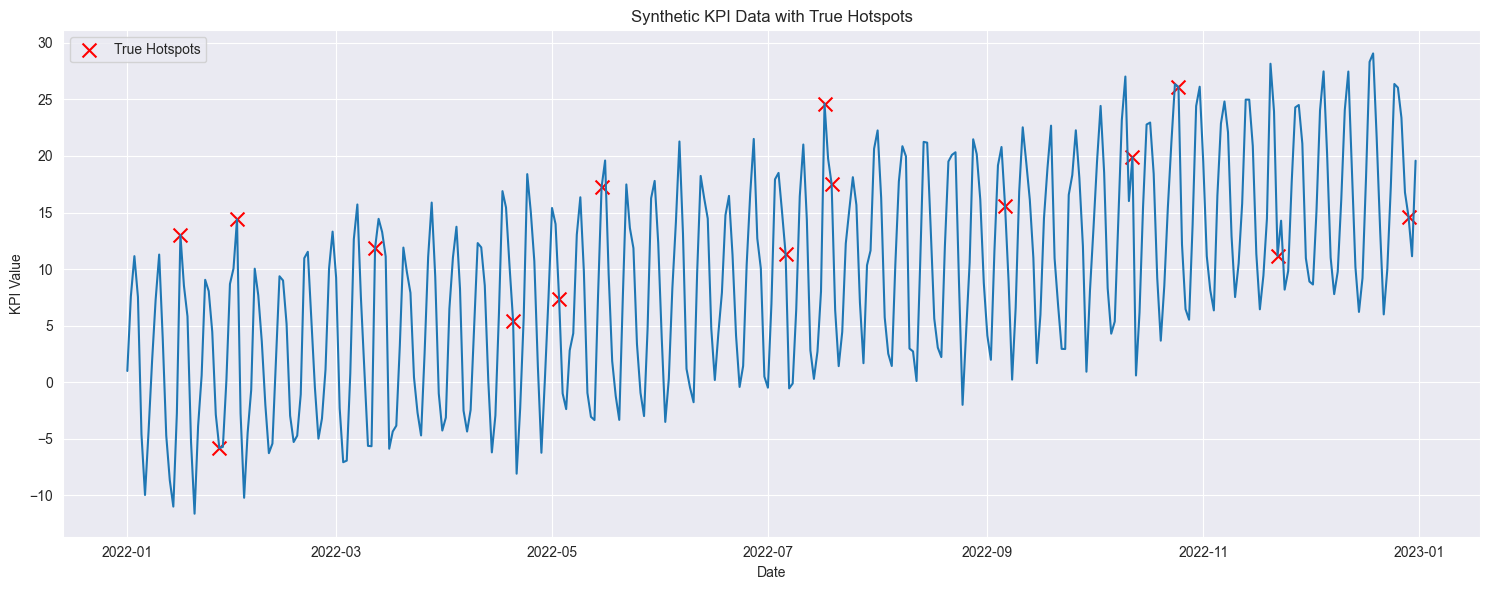

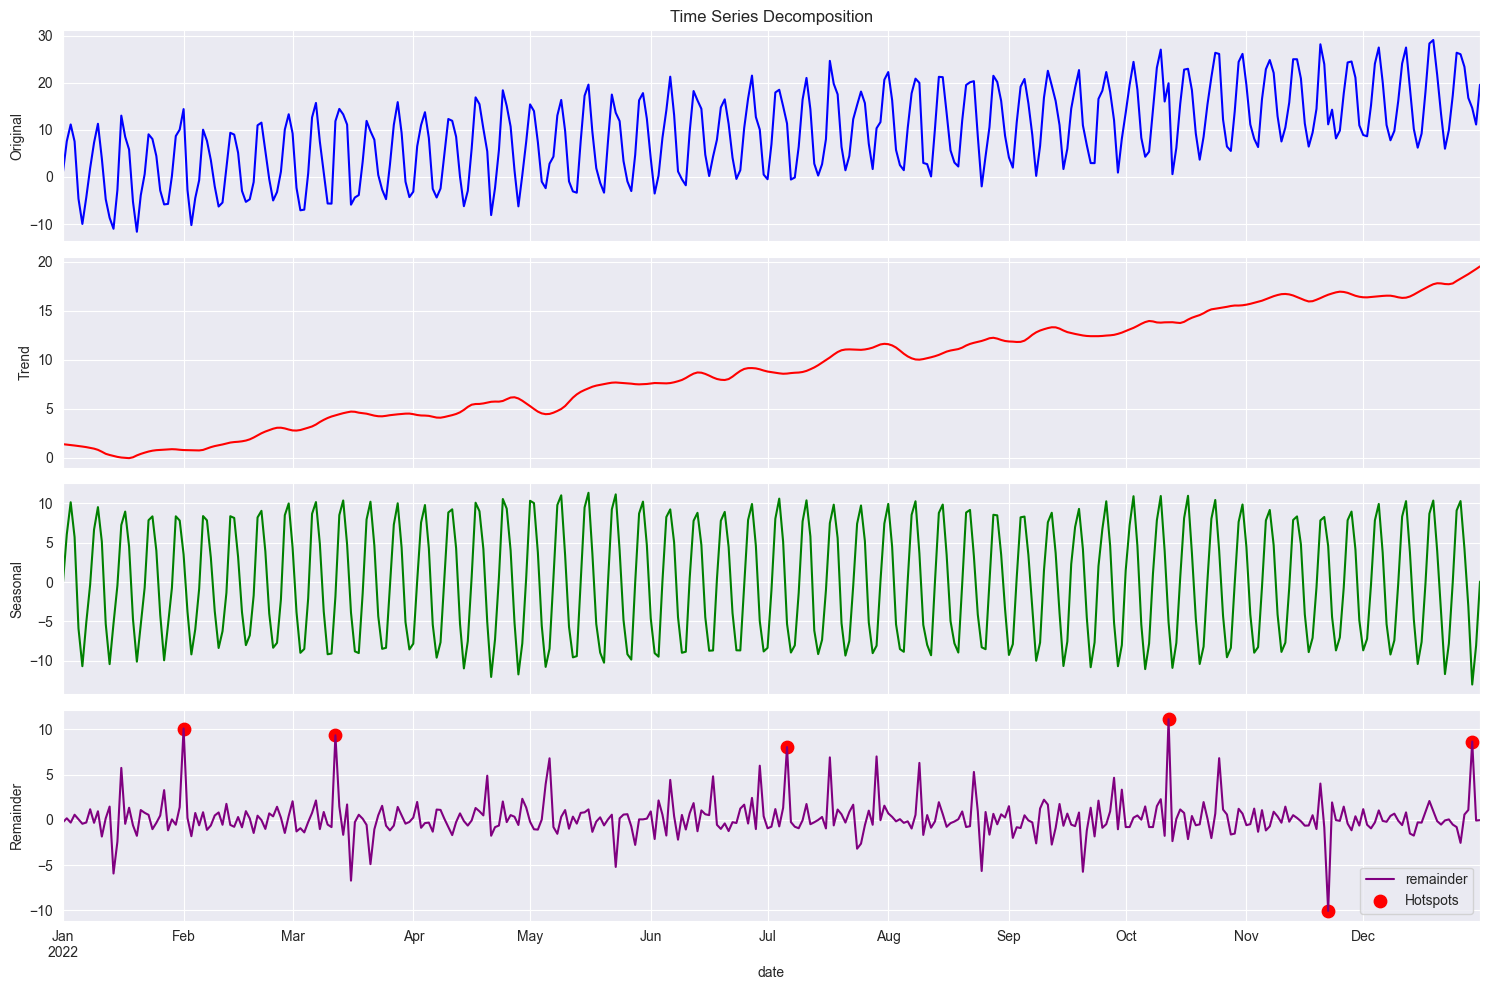

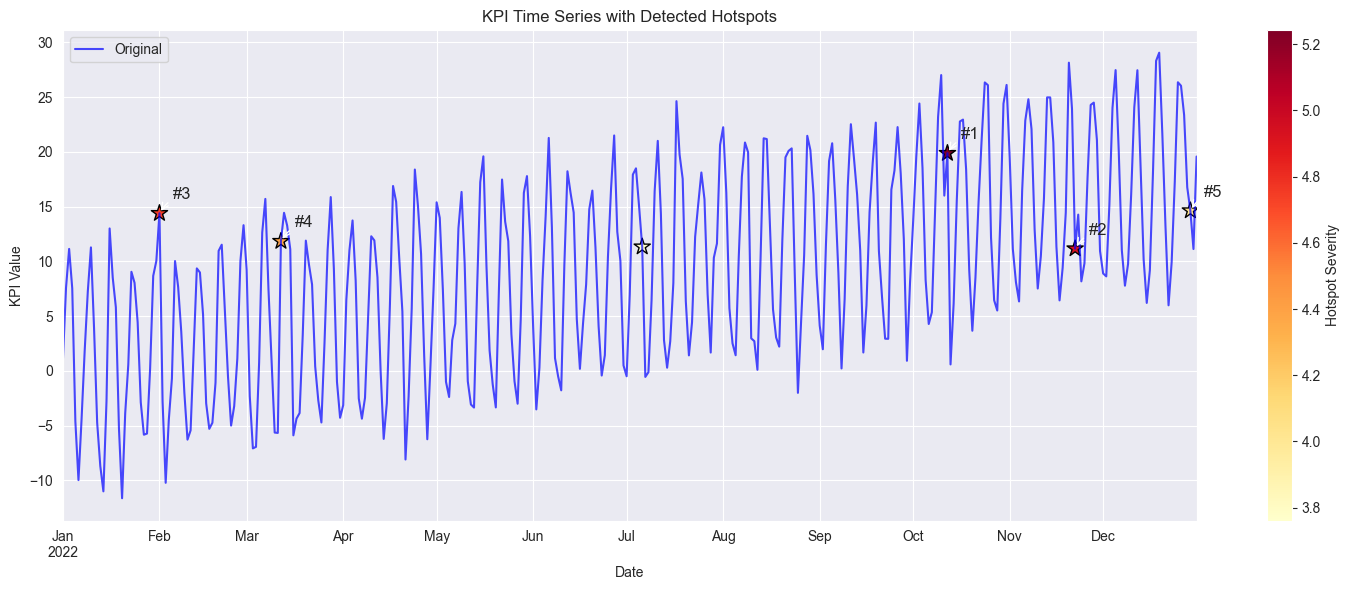

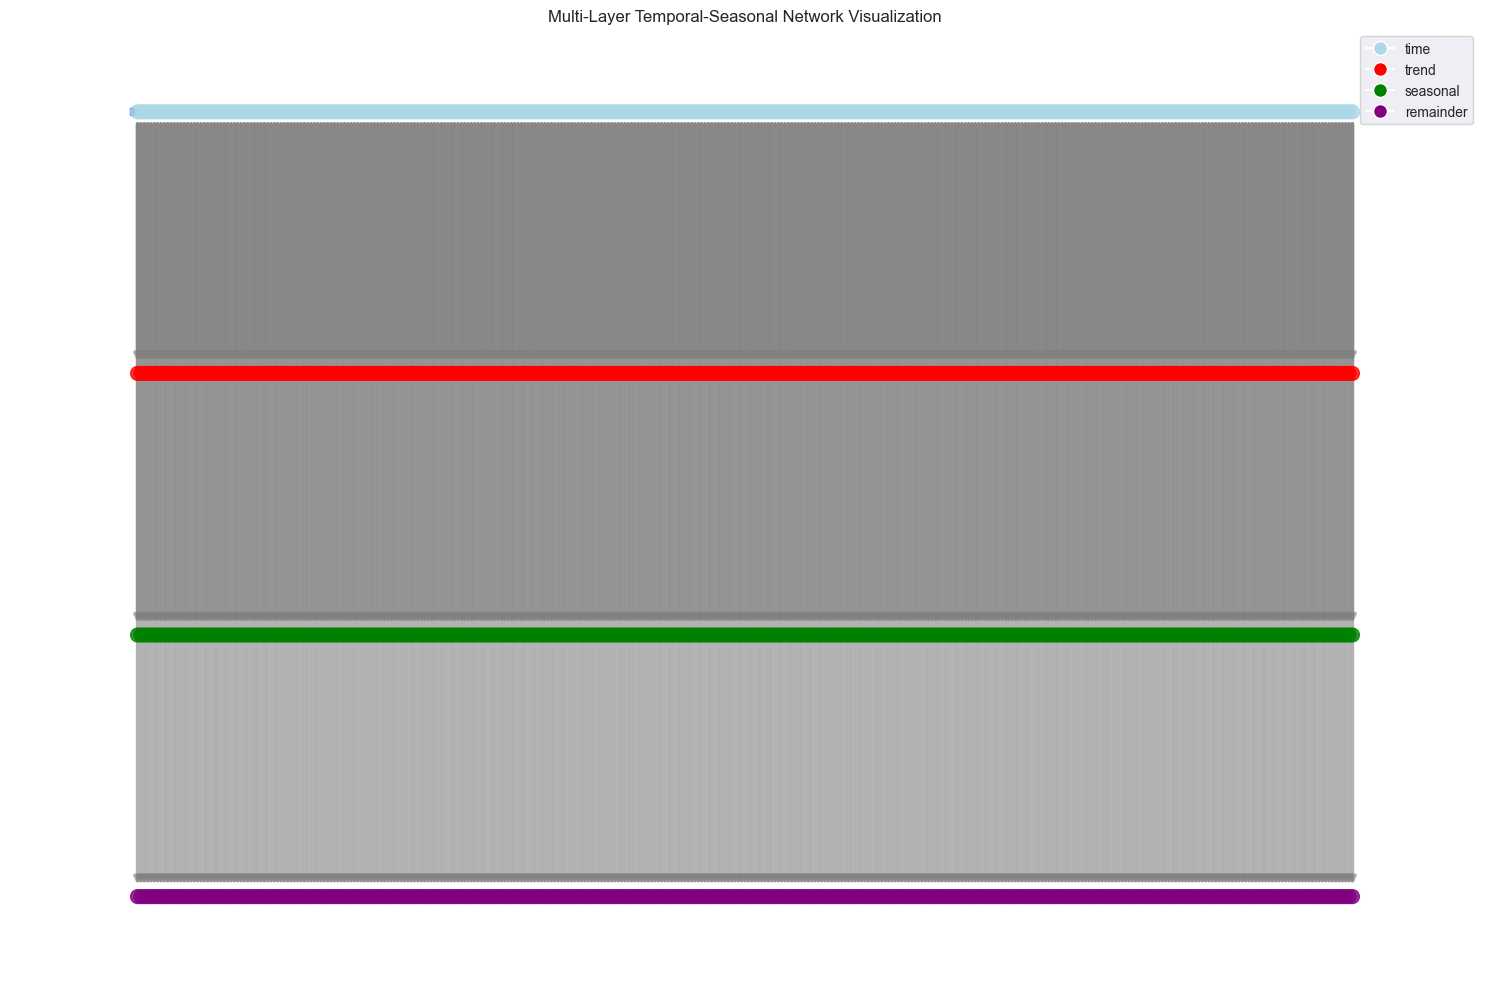

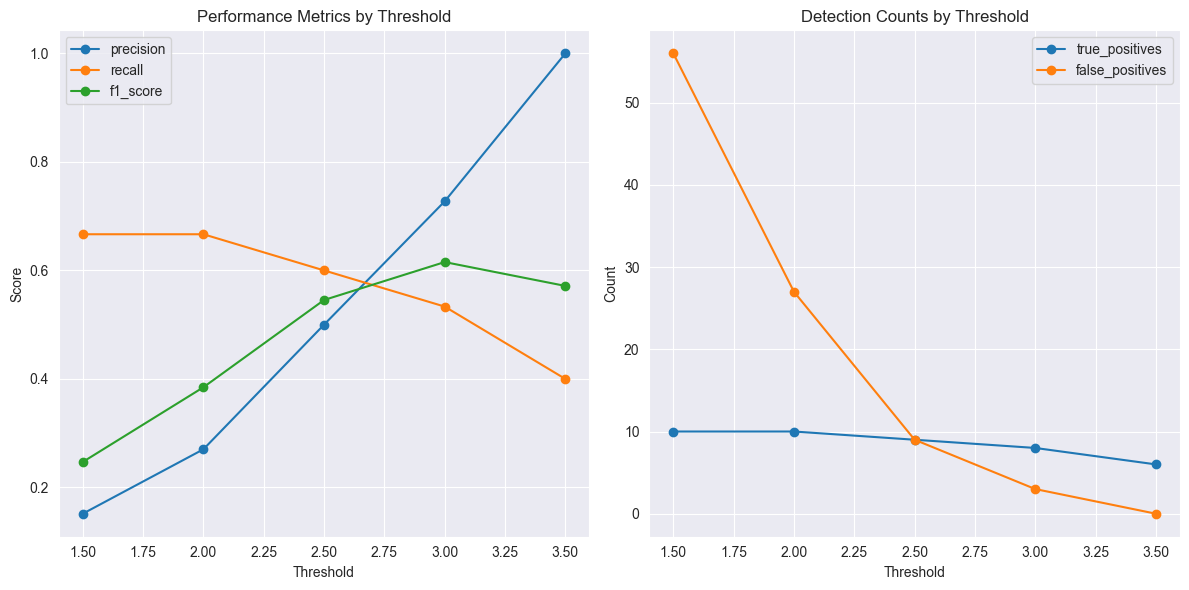

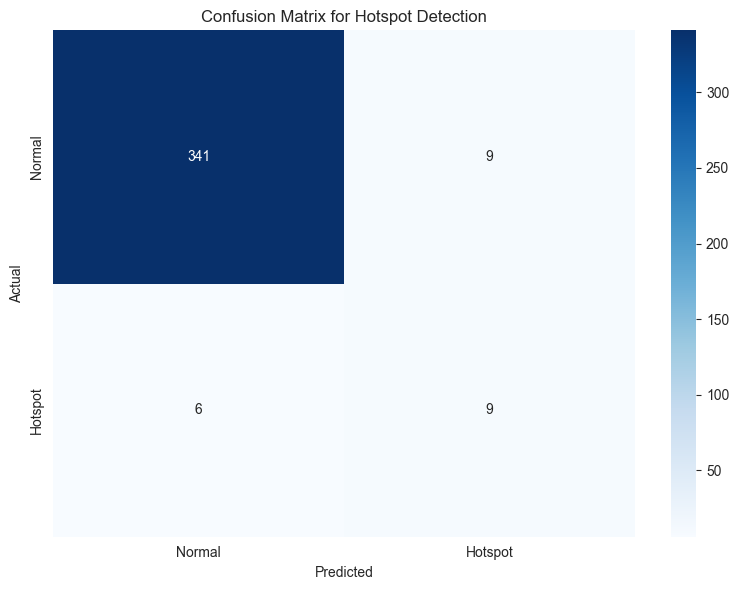


=== MTSN Validation Results ===
Precision: 0.5000
Recall: 0.6000
F1 Score: 0.5455

Confusion Matrix:
[[341   9]
 [  6   9]]

Temporal Integration Validation:
  interval  mtsn_original_integration  manual_integration  relative_error_pct
0       Q1                 211.155074          211.155074                 0.0
1       Q2                 628.131110          628.131110                 0.0

Best Threshold:
Threshold: 3.0
Precision: 0.7273
Recall: 0.5333
F1 Score: 0.6154


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import warnings
warnings.filterwarnings("ignore")


class MTSNValidator:
    """
    Validator for MTSN framework using synthetic data with known patterns and hotspots.
    """

    def __init__(self, random_seed=42):
        """
        Initialize the validator with a random seed for reproducibility.

        Parameters:
        -----------
        random_seed : int
            Random seed for reproducibility
        """
        self.random_seed = random_seed
        np.random.seed(random_seed)
        self.synthetic_data = None
        self.true_hotspots = None
        self.mtsn = None

    def generate_synthetic_data(self, start_date='2022-01-01', n_days=365,
                              trend_factor=0.05, seasonal_amplitude=10,
                              seasonal_period=7, noise_level=2,
                              hotspot_count=10, hotspot_magnitude=5):
        """
        Generate synthetic KPI data with known trend, seasonality, and hotspots.

        Parameters:
        -----------
        start_date : str
            Start date for the time series
        n_days : int
            Number of days to generate
        trend_factor : float
            Slope of the linear trend
        seasonal_amplitude : float
            Amplitude of the seasonal component
        seasonal_period : int
            Period of the seasonal component
        noise_level : float
            Standard deviation of the random noise
        hotspot_count : int
            Number of hotspots to generate
        hotspot_magnitude : float
            Magnitude of the hotspot anomalies

        Returns:
        --------
        self : MTSNValidator
            Returns self for method chaining
        """
        # Generate date range
        dates = [pd.to_datetime(start_date) + timedelta(days=i) for i in range(n_days)]

        # Generate trend component
        trend = np.arange(n_days) * trend_factor

        # Generate seasonal component
        seasonal = seasonal_amplitude * np.sin(2 * np.pi * np.arange(n_days) / seasonal_period)

        # Generate random noise
        noise = np.random.normal(0, noise_level, n_days)

        # Combine components
        kpi_values = trend + seasonal + noise

        # Insert anomalies (hotspots)
        hotspot_indices = np.random.choice(range(n_days), size=hotspot_count, replace=False)
        self.true_hotspots = hotspot_indices.tolist()

        for idx in hotspot_indices:
            # Randomly determine if this is a positive or negative anomaly
            direction = 1 if np.random.random() > 0.5 else -1
            kpi_values[idx] += direction * hotspot_magnitude * (1 + np.random.random())

        # Create DataFrame
        self.synthetic_data = pd.DataFrame({
            'date': dates,
            'kpi_value': kpi_values
        })

        print(f"Generated synthetic data with {n_days} days and {hotspot_count} hotspots.")
        print(f"True hotspot indices: {sorted(self.true_hotspots)}")

        return self

    def run_mtsn_analysis(self, hotspot_threshold=2.5):
        """
        Run MTSN analysis on the synthetic data.

        Parameters:
        -----------
        hotspot_threshold : float
            Z-score threshold for hotspot detection

        Returns:
        --------
        self : MTSNValidator
            Returns self for method chaining
        """
        if self.synthetic_data is None:
            raise ValueError("Synthetic data has not been generated. Call generate_synthetic_data() first.")

        # Create and run MTSN
        self.mtsn = MTSN(
            data=self.synthetic_data,
            date_column='date',
            value_column='kpi_value',
            period=7,  # Weekly seasonality
            hotspot_threshold=hotspot_threshold
        )

        # Run the analysis pipeline
        self.mtsn.decompose(robust=True)
        self.mtsn.construct_graph()
        self.mtsn.detect_hotspots()

        return self

    def evaluate_performance(self):
        """
        Evaluate MTSN performance against known ground truth.

        Returns:
        --------
        dict
            Dictionary with performance metrics
        """
        if self.mtsn is None or self.true_hotspots is None:
            raise ValueError("MTSN analysis has not been run. Call run_mtsn_analysis() first.")

        # Get detected hotspot indices
        detected_indices = [h['index'] for h in self.mtsn.hotspots]

        # Create binary arrays for ground truth and predictions
        n_days = len(self.synthetic_data)
        y_true = np.zeros(n_days)
        y_pred = np.zeros(n_days)

        y_true[self.true_hotspots] = 1
        y_pred[detected_indices] = 1

        # Calculate metrics
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)

        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)

        return {
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'confusion_matrix': cm,
            'true_positives': cm[1, 1],
            'false_positives': cm[0, 1],
            'false_negatives': cm[1, 0],
            'true_negatives': cm[0, 0]
        }

    def compare_thresholds(self, thresholds=[1.5, 2.0, 2.5, 3.0, 3.5]):
        """
        Compare performance with different hotspot detection thresholds.

        Parameters:
        -----------
        thresholds : list
            List of thresholds to evaluate

        Returns:
        --------
        pandas.DataFrame
            DataFrame with performance metrics for each threshold
        """
        results = []

        for threshold in thresholds:
            self.run_mtsn_analysis(hotspot_threshold=threshold)
            metrics = self.evaluate_performance()

            results.append({
                'threshold': threshold,
                'precision': metrics['precision'],
                'recall': metrics['recall'],
                'f1_score': metrics['f1_score'],
                'true_positives': metrics['true_positives'],
                'false_positives': metrics['false_positives']
            })

        return pd.DataFrame(results)

    def validate_temporal_integration(self):
        """
        Validate the temporal integration calculation against direct calculation.

        Returns:
        --------
        dict
            Dictionary with validation metrics
        """
        if self.mtsn is None:
            raise ValueError("MTSN analysis has not been run. Call run_mtsn_analysis() first.")

        # Define test intervals (quarters)
        start_date = self.synthetic_data['date'].min()
        end_date = self.synthetic_data['date'].max()

        q1_start = start_date
        q1_end = start_date + pd.Timedelta(days=90)
        q2_start = q1_end + pd.Timedelta(days=1)
        q2_end = q2_start + pd.Timedelta(days=90)

        intervals = [
            (q1_start, q1_end, 'Q1'),
            (q2_start, q2_end, 'Q2')
        ]

        results = []

        for start, end, label in intervals:
            # Calculate using MTSN
            mtsn_trend_integration = self.mtsn.calculate_temporal_integration(
                start_date=start, end_date=end, component='trend')

            mtsn_original_integration = self.mtsn.calculate_temporal_integration(
                start_date=start, end_date=end, component='original')

            mtsn_seasonal_integration = self.mtsn.calculate_temporal_integration(
                start_date=start, end_date=end, component='seasonal')

            # Manual calculation for validation
            mask = (self.synthetic_data['date'] >= start) & (self.synthetic_data['date'] <= end)
            subset = self.synthetic_data[mask]

            # Calculate time deltas
            time_deltas = [(t - subset['date'].iloc[0]).total_seconds() / (24*3600)
                          for t in subset['date']]

            # Perform trapezoidal integration
            from scipy import integrate
            manual_integration = integrate.trapezoid(subset['kpi_value'], time_deltas)

            # Calculate relative error
            rel_error = abs(mtsn_original_integration - manual_integration) / abs(manual_integration) * 100

            # Verify seasonal integration sums close to zero over complete cycles
            seasonal_sum = mtsn_seasonal_integration / abs(mtsn_original_integration) * 100

            results.append({
                'interval': label,
                'start_date': start,
                'end_date': end,
                'mtsn_trend_integration': mtsn_trend_integration,
                'mtsn_original_integration': mtsn_original_integration,
                'mtsn_seasonal_integration': mtsn_seasonal_integration,
                'manual_integration': manual_integration,
                'relative_error_pct': rel_error,
                'seasonal_pct': seasonal_sum
            })

        return pd.DataFrame(results)

    def run_full_validation(self, display_plots=True):
        """
        Run a full validation suite on the MTSN framework.

        Parameters:
        -----------
        display_plots : bool
            Whether to display validation plots

        Returns:
        --------
        dict
            Dictionary with all validation results
        """
        # Generate synthetic data
        self.generate_synthetic_data(
            n_days=365,
            trend_factor=0.05,
            seasonal_amplitude=10,
            seasonal_period=7,
            noise_level=2,
            hotspot_count=15,
            hotspot_magnitude=4
        )

        # Run MTSN analysis
        self.run_mtsn_analysis(hotspot_threshold=2.5)

        # Evaluate performance
        performance = self.evaluate_performance()

        # Compare different thresholds
        threshold_comparison = self.compare_thresholds()

        # Validate temporal integration
        integration_validation = self.validate_temporal_integration()

        # Display plots if requested
        if display_plots:
            # Plot synthetic data
            plt.figure(figsize=(15, 6))
            plt.plot(self.synthetic_data['date'], self.synthetic_data['kpi_value'])
            plt.scatter(self.synthetic_data.iloc[self.true_hotspots]['date'],
                      self.synthetic_data.iloc[self.true_hotspots]['kpi_value'],
                      color='red', marker='x', s=100, label='True Hotspots')
            plt.title('Synthetic KPI Data with True Hotspots')
            plt.xlabel('Date')
            plt.ylabel('KPI Value')
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Plot decomposition
            self.mtsn.plot_decomposition()
            plt.tight_layout()
            plt.show()

            # Plot hotspots
            self.mtsn.plot_hotspots()
            plt.tight_layout()
            plt.show()

            # Plot graph visualization
            self.mtsn.plot_graph_visualization(node_types=['time', 'trend', 'seasonal', 'remainder'])
            plt.tight_layout()
            plt.show()

            # Plot threshold comparison
            plt.figure(figsize=(12, 6))
            ax1 = plt.subplot(1, 2, 1)
            threshold_comparison.plot(x='threshold', y=['precision', 'recall', 'f1_score'],
                                    marker='o', ax=ax1)
            ax1.set_title('Performance Metrics by Threshold')
            ax1.set_xlabel('Threshold')
            ax1.set_ylabel('Score')
            ax1.grid(True)

            ax2 = plt.subplot(1, 2, 2)
            threshold_comparison.plot(x='threshold', y=['true_positives', 'false_positives'],
                                    marker='o', ax=ax2)
            ax2.set_title('Detection Counts by Threshold')
            ax2.set_xlabel('Threshold')
            ax2.set_ylabel('Count')
            ax2.grid(True)

            plt.tight_layout()
            plt.show()

            # Plot confusion matrix
            plt.figure(figsize=(8, 6))
            sns.heatmap(performance['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Normal', 'Hotspot'], yticklabels=['Normal', 'Hotspot'])
            plt.title('Confusion Matrix for Hotspot Detection')
            plt.xlabel('Predicted')
            plt.ylabel('Actual')
            plt.tight_layout()
            plt.show()

        return {
            'performance': performance,
            'threshold_comparison': threshold_comparison,
            'integration_validation': integration_validation
        }

# Run validation
validator = MTSNValidator(random_seed=42)
validation_results = validator.run_full_validation(display_plots=True)

# Print summary results
print("\n=== MTSN Validation Results ===")
print(f"Precision: {validation_results['performance']['precision']:.4f}")
print(f"Recall: {validation_results['performance']['recall']:.4f}")
print(f"F1 Score: {validation_results['performance']['f1_score']:.4f}")
print("\nConfusion Matrix:")
print(validation_results['performance']['confusion_matrix'])

print("\nTemporal Integration Validation:")
print(validation_results['integration_validation'][['interval', 'mtsn_original_integration',
                                                  'manual_integration', 'relative_error_pct']])

print("\nBest Threshold:")
best_threshold = validation_results['threshold_comparison'].iloc[
    validation_results['threshold_comparison']['f1_score'].argmax()
]
print(f"Threshold: {best_threshold['threshold']}")
print(f"Precision: {best_threshold['precision']:.4f}")
print(f"Recall: {best_threshold['recall']:.4f}")
print(f"F1 Score: {best_threshold['f1_score']:.4f}")


Initialized FRED validator for period 2010-01-01 to 2025-03-05

Analyzing Consumer Price Index...
Loaded 181 observations with seasonal period 12
Decomposition completed.
Graph constructed with 785 nodes and 1251 edges.
Detected 10 hotspots.
Detected 10 hotspots in Consumer Price Index

Analyzing Unemployment Rate...
Loaded 181 observations with seasonal period 12
Decomposition completed.
Graph constructed with 785 nodes and 1249 edges.
Detected 4 hotspots.
Detected 4 hotspots in Unemployment Rate

Analyzing Retail Sales...
Loaded 181 observations with seasonal period 12
Decomposition completed.
Graph constructed with 785 nodes and 1248 edges.
Detected 7 hotspots.
Detected 7 hotspots in Retail Sales


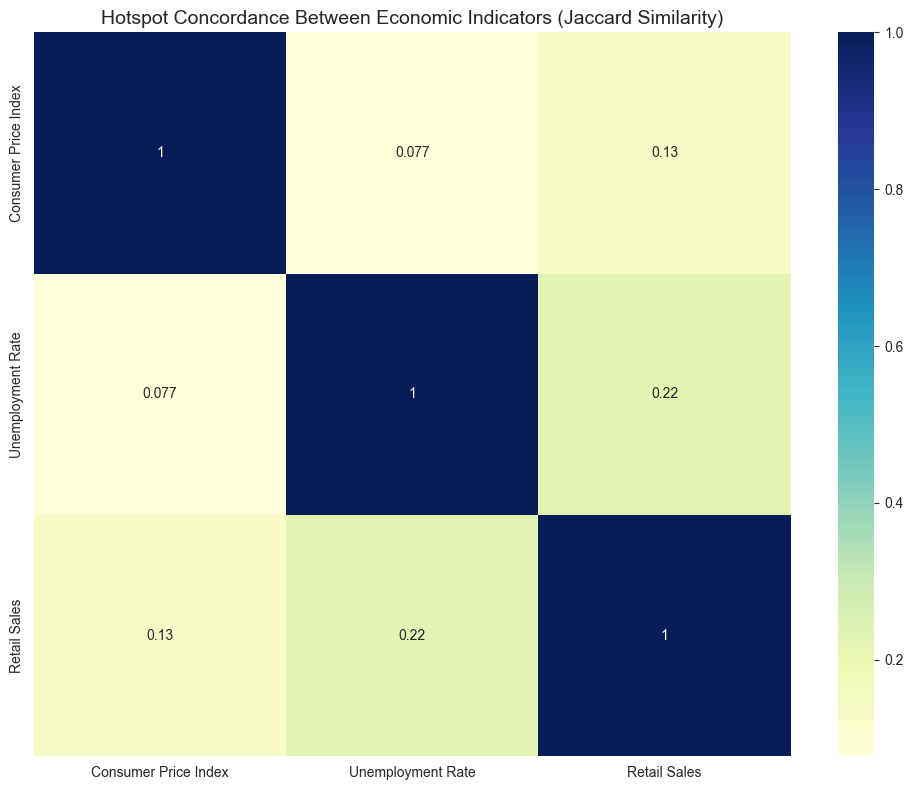


Plotting decomposition for Consumer Price Index...


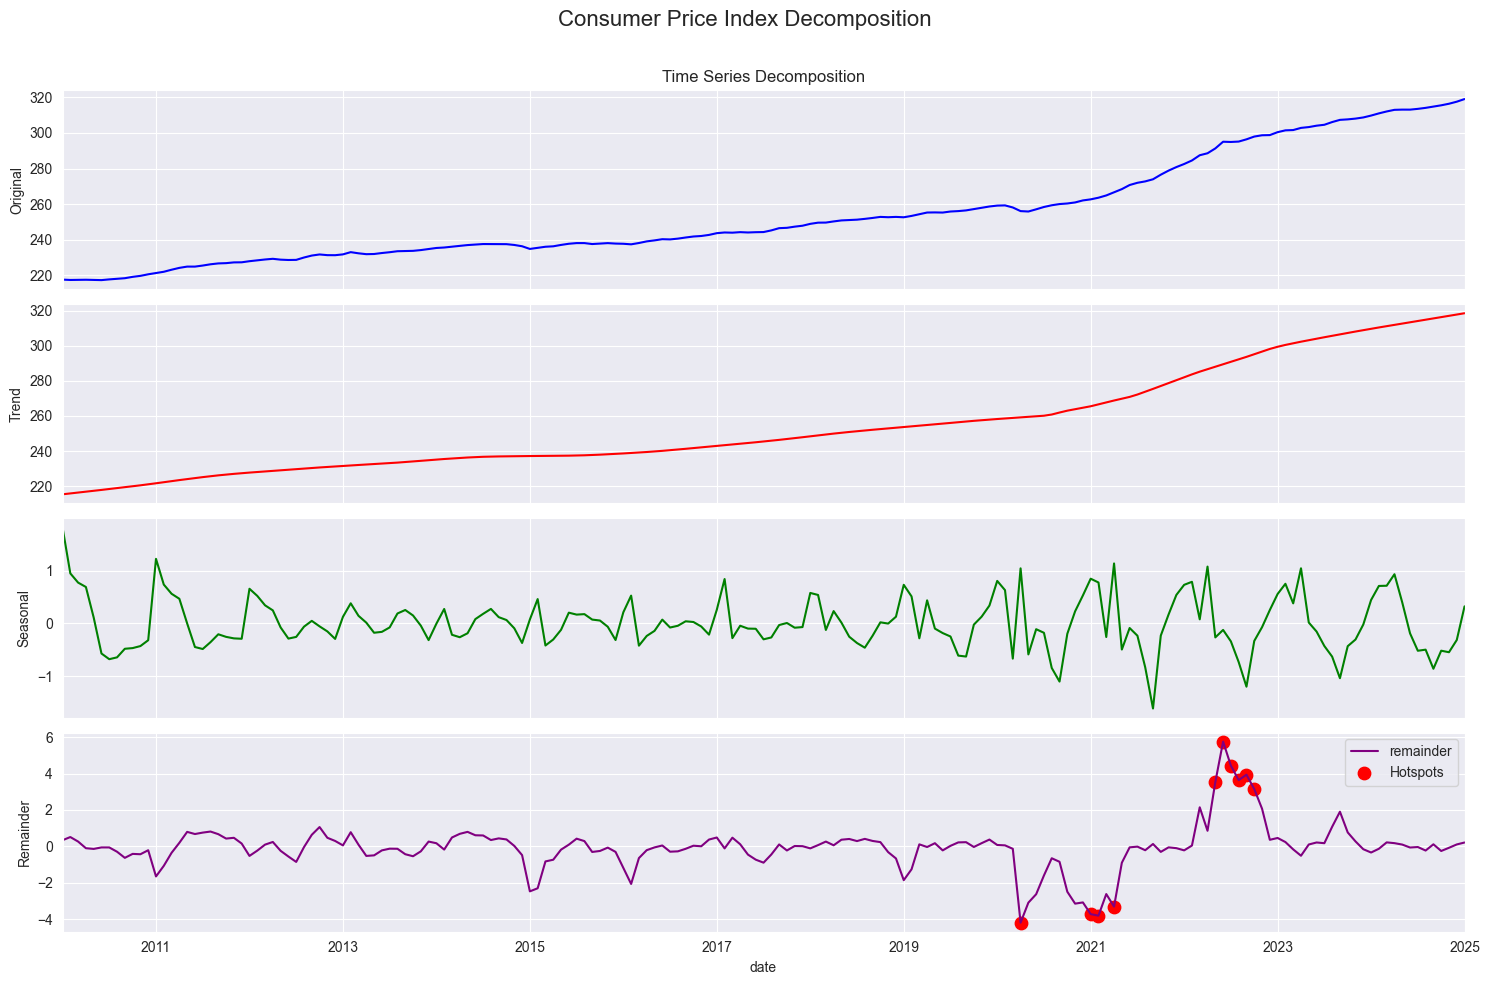


Plotting decomposition for Unemployment Rate...


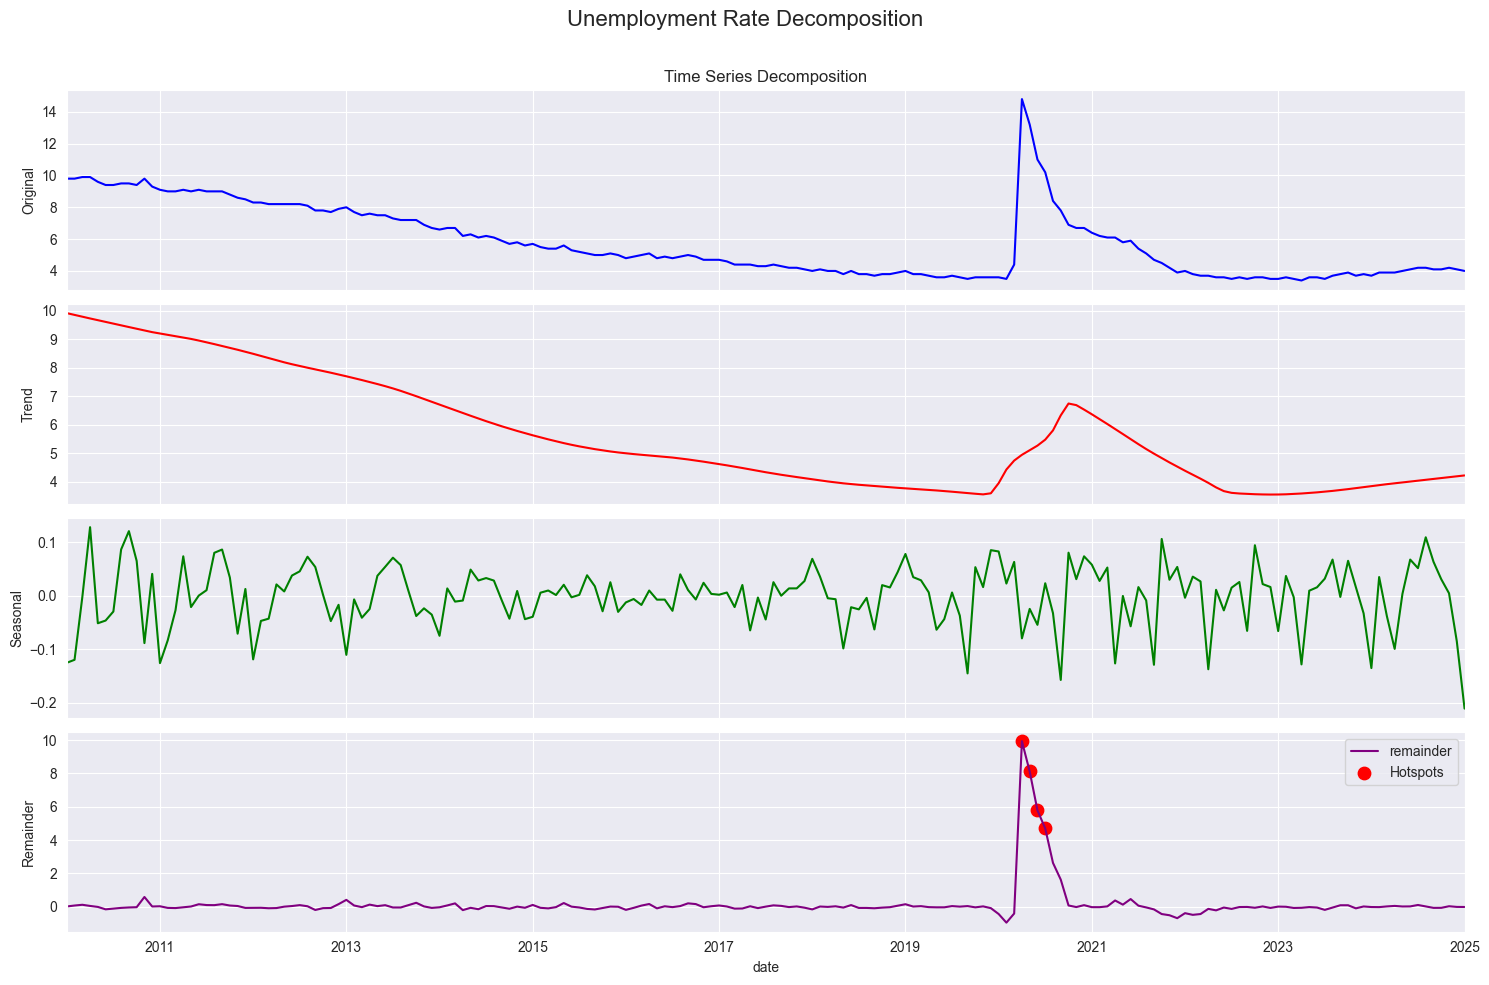


Plotting decomposition for Retail Sales...


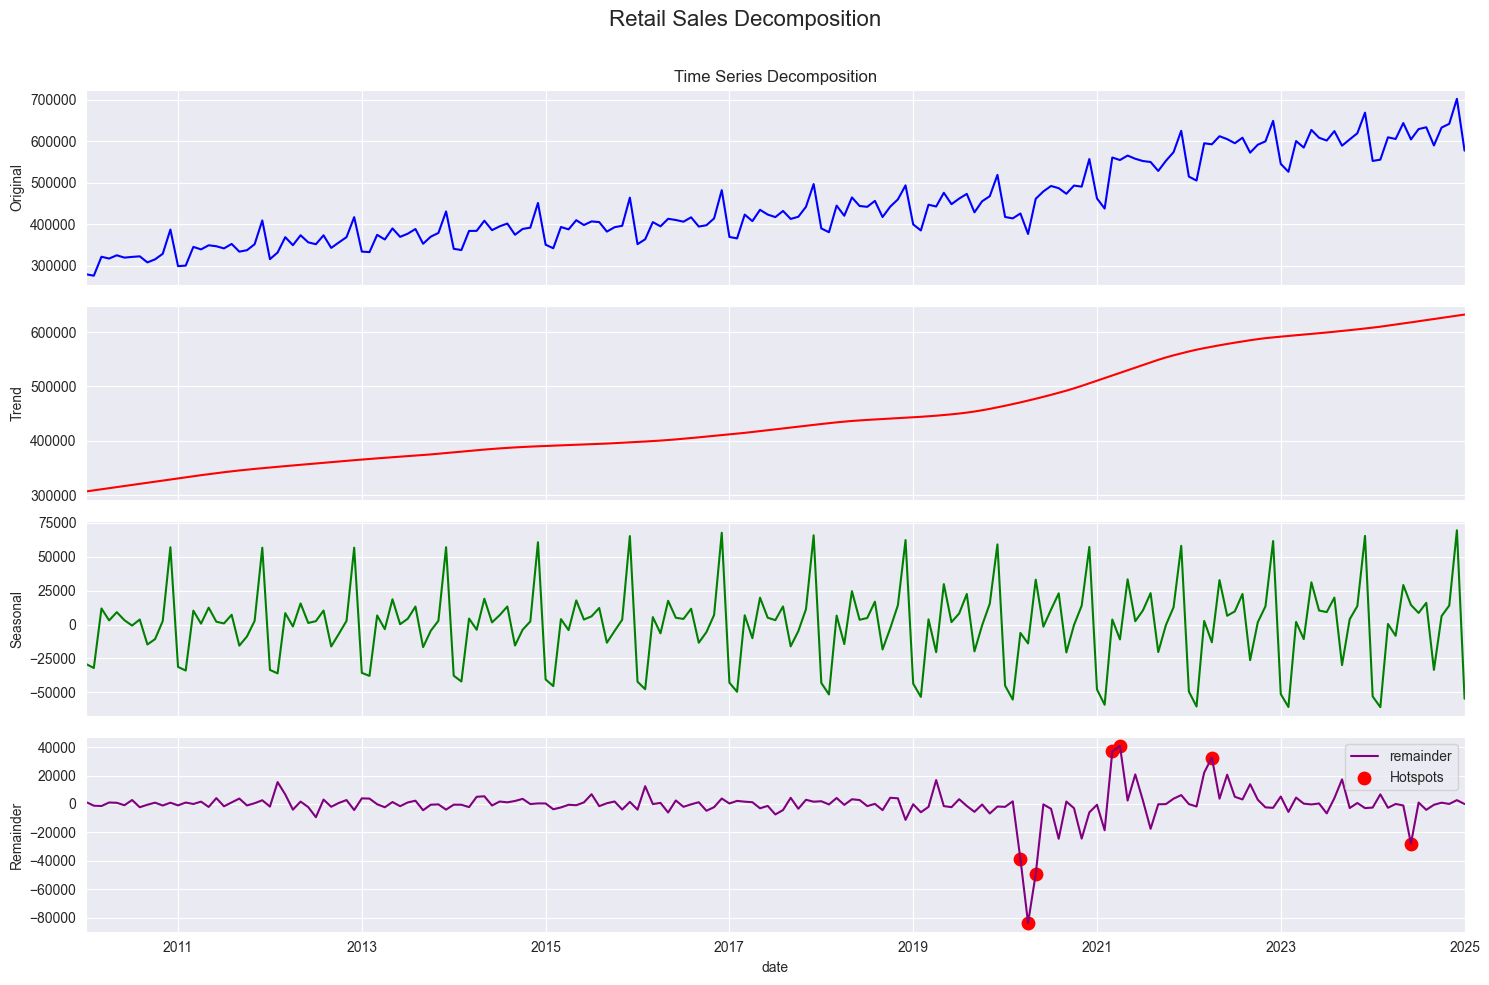


Plotting hotspots for Consumer Price Index...


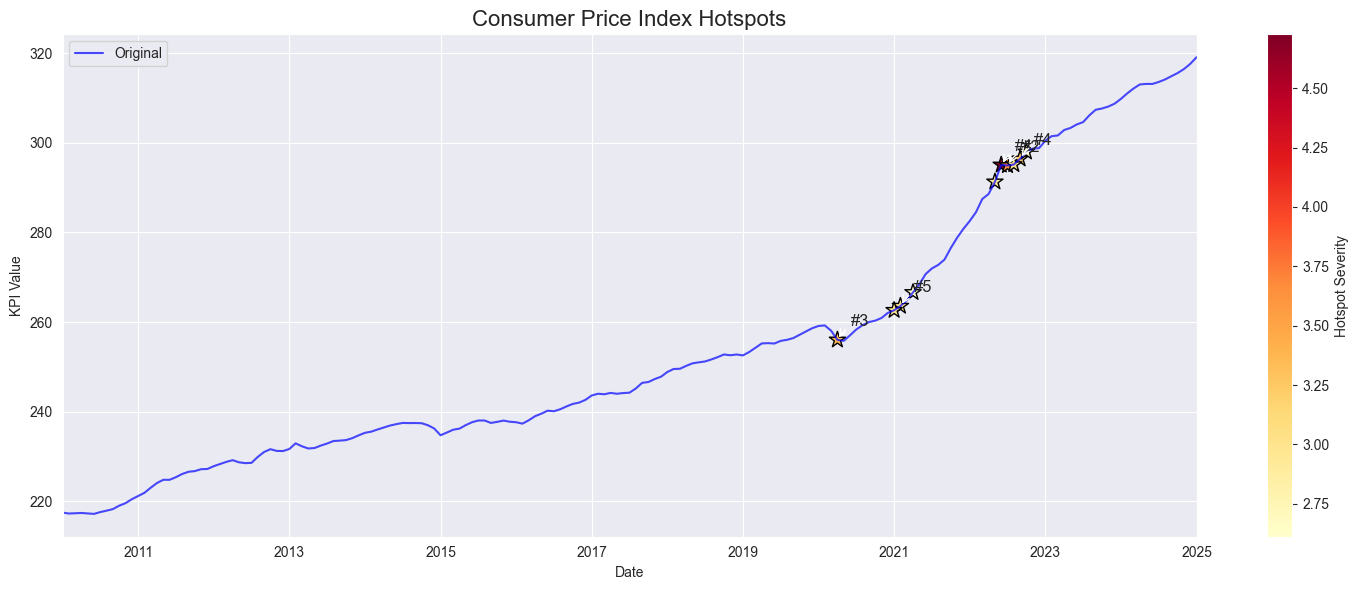


Plotting hotspots for Unemployment Rate...


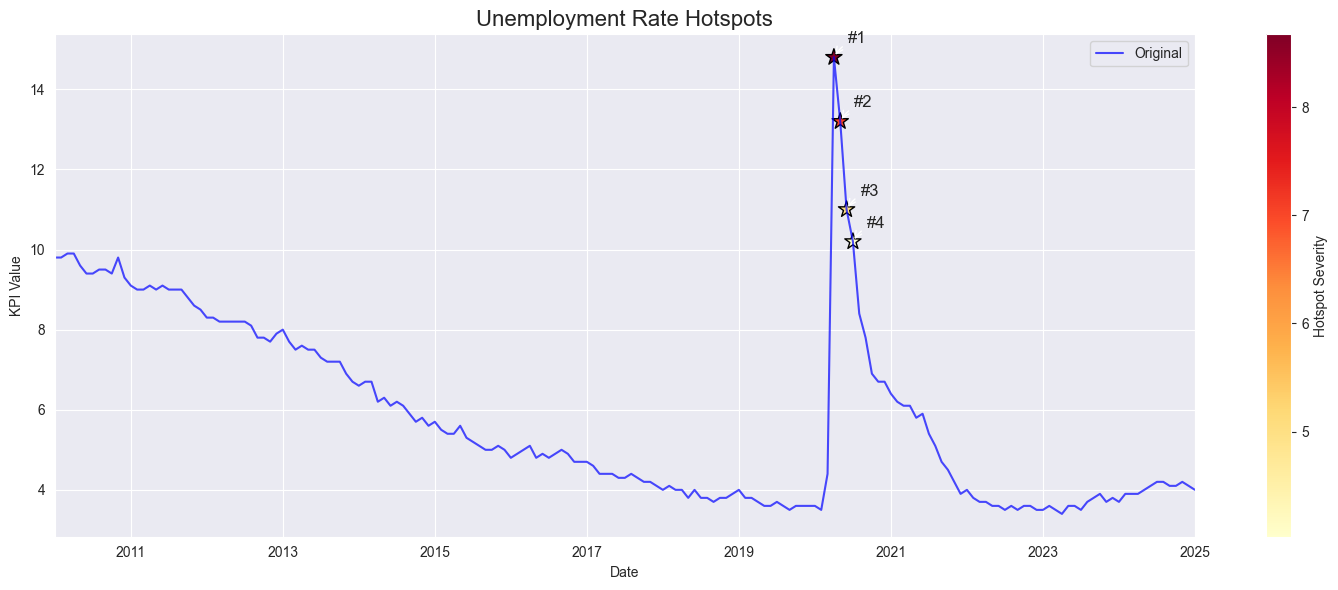


Plotting hotspots for Retail Sales...


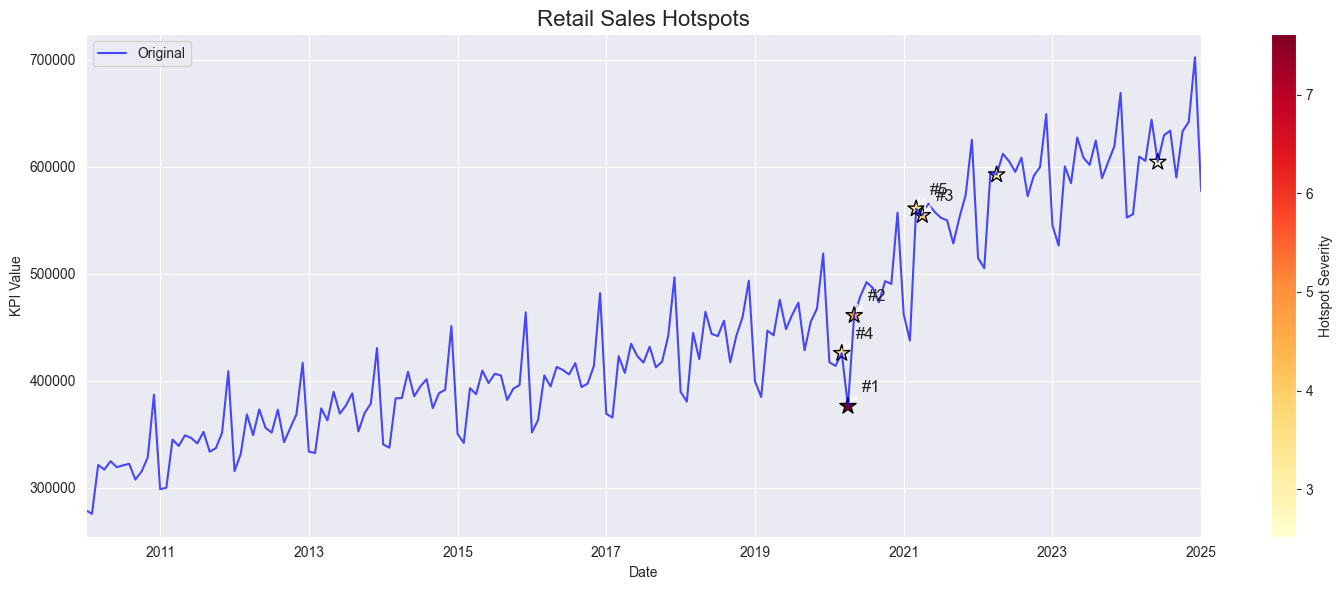

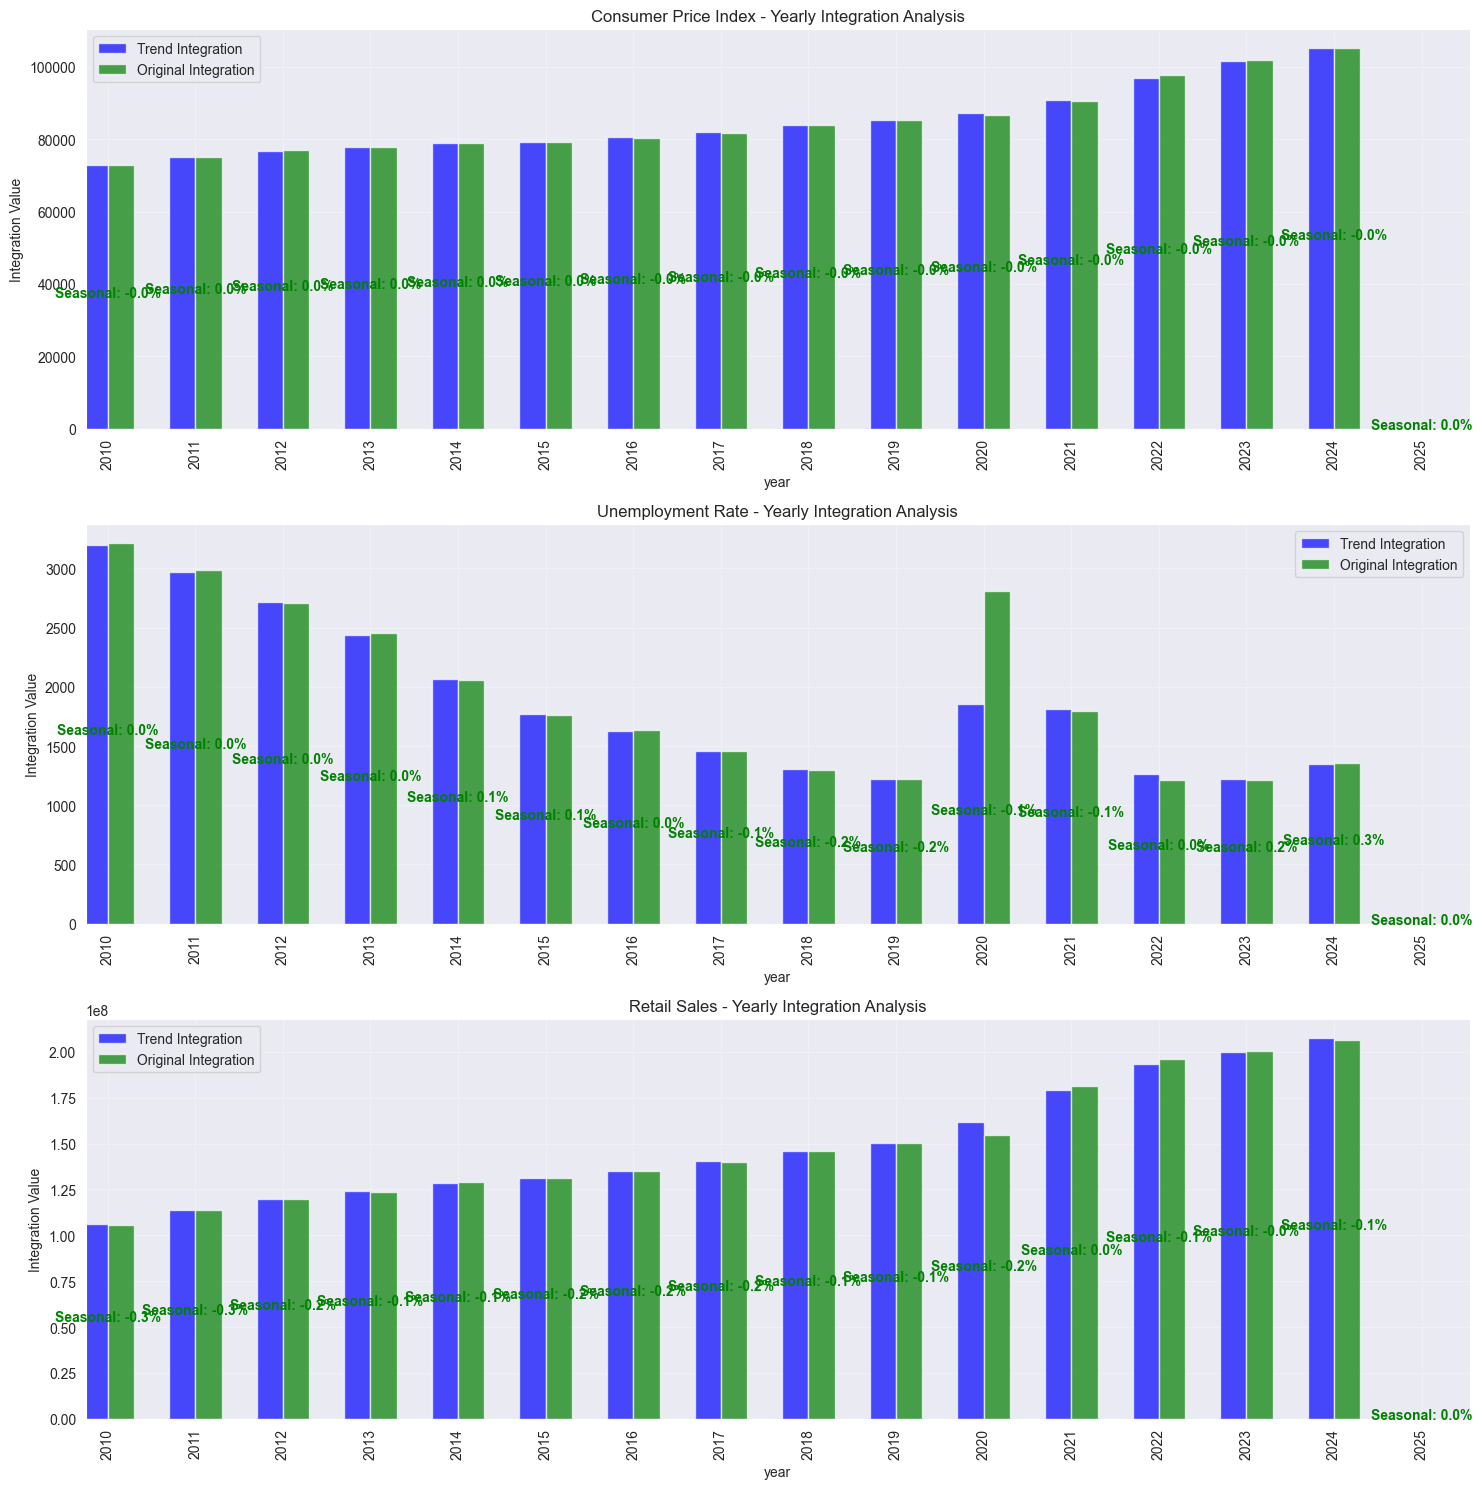

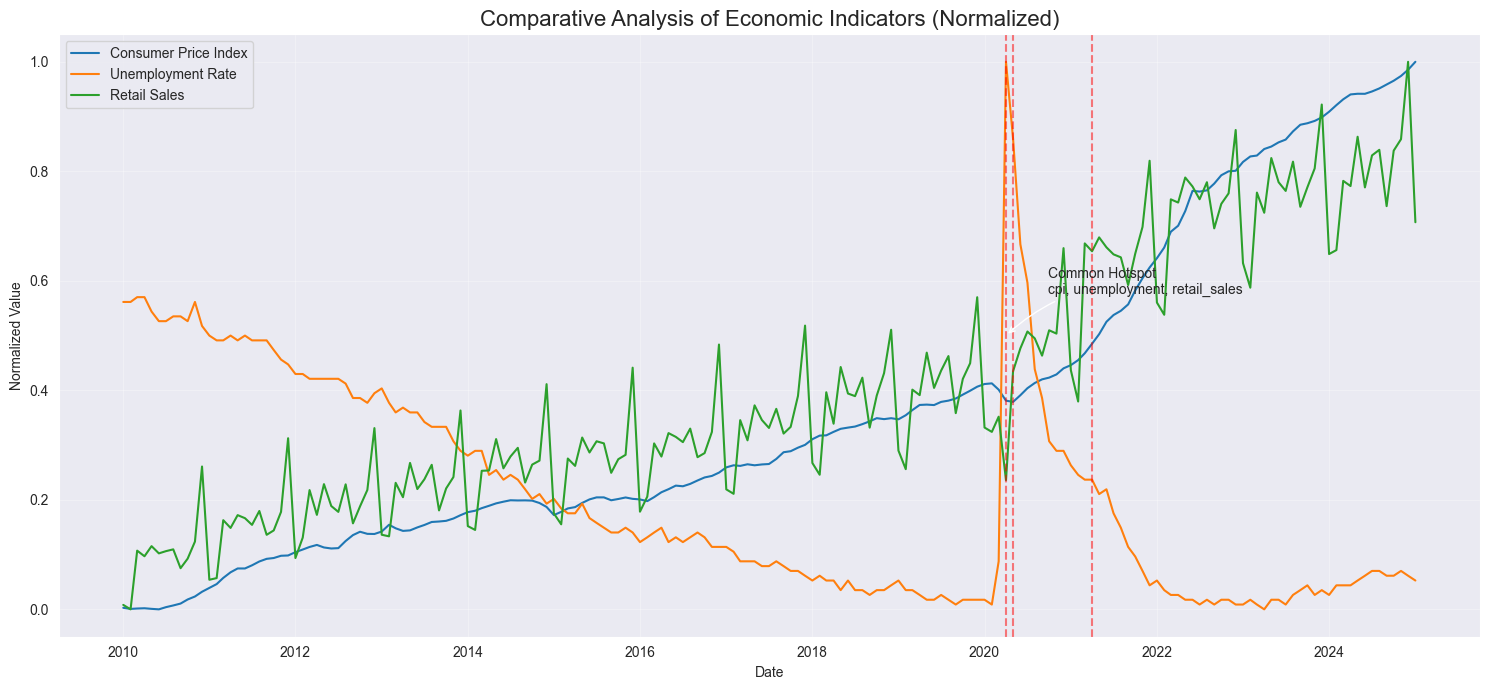


===== FRED MTSN Analysis Summary =====

Hotspot Detection:
  Consumer Price Index: 10 hotspots detected
  Unemployment Rate: 4 hotspots detected
  Retail Sales: 7 hotspots detected

Top Common Hotspot Periods:
  2020-04: 3 indicators (cpi, unemployment, retail_sales)
  2020-05: 2 indicators (unemployment, retail_sales)
  2021-04: 2 indicators (cpi, retail_sales)
  2020-03: 1 indicators (retail_sales)
  2020-06: 1 indicators (unemployment)

Hotspot Concordance:
  Highest similarity: Unemployment Rate and Retail Sales
  Jaccard similarity: 0.2222
  Agreement: 96.13%
  Joint hotspots: 2


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_datareader.data as web
from datetime import datetime
import matplotlib.dates as mdates
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings("ignore")


class FREDValidator:
    """
    Class to validate MTSN framework using FRED economic data.
    """

    def __init__(self, start_date='2010-01-01', end_date=None):
        """
        Initialize the validator with date range.

        Parameters:
        -----------
        start_date : str
            Start date for data retrieval
        end_date : str
            End date for data retrieval (defaults to current date if None)
        """
        self.start_date = start_date
        self.end_date = end_date if end_date else datetime.now().strftime('%Y-%m-%d')

        # Data storage
        self.datasets = {}
        self.mtsn_results = {}

        # Define FRED series information
        self.series_info = {
            'cpi': {
                'id': 'CPIAUCSL',
                'name': 'Consumer Price Index',
                'frequency': 'monthly',
                'period': 12
            },
            'unemployment': {
                'id': 'UNRATE',
                'name': 'Unemployment Rate',
                'frequency': 'monthly',
                'period': 12
            },
            'retail_sales': {
                'id': 'RSXFSN',
                'name': 'Retail Sales',
                'frequency': 'monthly',
                'period': 12
            }
        }

        print(f"Initialized FRED validator for period {self.start_date} to {self.end_date}")

    def fetch_fred_data(self, series_id, name):
        """
        Fetch data from FRED database.

        Parameters:
        -----------
        series_id : str
            FRED series ID
        name : str
            Descriptive name for the series

        Returns:
        --------
        pandas.DataFrame
            DataFrame with the FRED data
        """
        if not os.path.exists(f'fred-{name}.parquet'):
            data = web.DataReader(series_id, 'fred', self.start_date, self.end_date)
            data = data.reset_index()
            data.columns = ['date', 'value']
            data.to_parquet(f'fred-{name}.parquet')
        return pd.read_parquet(f'fred-{name}.parquet')

    def load_datasets(self):
        """
        Load all FRED datasets defined in series_info.

        Returns:
        --------
        self : FREDValidator
            Returns self for method chaining
        """
        for key, info in self.series_info.items():
            data = self.fetch_fred_data(info['id'], info['name'])
            if data is not None:
                self.datasets[key] = data

        return self

    def analyze_with_mtsn(self, hotspot_threshold=2.5):
        """
        Apply MTSN analysis to all loaded datasets.

        Parameters:
        -----------
        hotspot_threshold : float
            Z-score threshold for hotspot detection

        Returns:
        --------
        self : FREDValidator
            Returns self for method chaining
        """
        for key, data in self.datasets.items():
            print(f"\nAnalyzing {self.series_info[key]['name']}...")

            # Initialize MTSN
            mtsn = MTSN(
                data=data,
                date_column='date',
                value_column='value',
                period=self.series_info[key]['period'],
                hotspot_threshold=hotspot_threshold
            )

            # Run analysis pipeline
            mtsn.decompose(robust=True)
            mtsn.construct_graph()
            mtsn.detect_hotspots()

            # Store results
            self.mtsn_results[key] = {
                'mtsn': mtsn,
                'hotspots': mtsn.hotspots,
                'hotspot_count': len(mtsn.hotspots),
                'series_name': self.series_info[key]['name']
            }

            print(f"Detected {len(mtsn.hotspots)} hotspots in {self.series_info[key]['name']}")

        return self

    def analyze_temporal_integration(self):
        """
        Analyze temporal integration for different time periods in the data.

        Returns:
        --------
        dict
            Dictionary with integration results for each dataset
        """
        integration_results = {}

        for key, result in self.mtsn_results.items():
            mtsn = result['mtsn']
            data = self.datasets[key]

            # Define intervals for analysis (yearly)
            min_year = data['date'].min().year
            max_year = data['date'].max().year

            intervals = []
            for year in range(min_year, max_year + 1):
                start_date = f"{year}-01-01"
                end_date = f"{year}-12-31"
                intervals.append((start_date, end_date, str(year)))

            # Calculate integration for each interval
            year_results = []
            for start, end, label in intervals:
                try:
                    trend_integration = mtsn.calculate_temporal_integration(
                        start_date=start, end_date=end, component='trend')

                    original_integration = mtsn.calculate_temporal_integration(
                        start_date=start, end_date=end, component='original')

                    seasonal_impact = mtsn.calculate_temporal_integration(
                        start_date=start, end_date=end, component='seasonal')

                    year_results.append({
                        'year': label,
                        'trend_integration': trend_integration,
                        'original_integration': original_integration,
                        'seasonal_impact': seasonal_impact,
                        'seasonal_pct': (seasonal_impact / original_integration * 100) if original_integration != 0 else 0
                    })
                except Exception as e:
                    print(f"Error calculating integration for {key} in {label}: {str(e)}")

            integration_results[key] = pd.DataFrame(year_results)

        return integration_results

    def identify_common_hotspot_periods(self):
        """
        Identify time periods where multiple indicators show hotspots.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with common hotspot periods
        """
        # Convert hotspot dates to set for each indicator
        hotspot_dates = {}
        for key, result in self.mtsn_results.items():
            dates = [h['date'].strftime('%Y-%m') for h in result['hotspots']]
            hotspot_dates[key] = set(dates)

        # Find common periods (month-year)
        all_dates = set()
        for dates in hotspot_dates.values():
            all_dates.update(dates)

        # Count how many indicators have hotspots in each period
        common_periods = []
        for date in sorted(all_dates):
            count = sum(1 for key in hotspot_dates if date in hotspot_dates[key])
            indicators = [key for key in hotspot_dates if date in hotspot_dates[key]]

            common_periods.append({
                'period': date,
                'count': count,
                'indicators': ', '.join(indicators)
            })

        return pd.DataFrame(common_periods).sort_values(by=['count', 'period'], ascending=[False, True])

    def visualize_decomposition(self):
        """
        Create decomposition plots for all datasets.
        """
        for key, result in self.mtsn_results.items():
            print(f"\nPlotting decomposition for {result['series_name']}...")
            fig = result['mtsn'].plot_decomposition()
            plt.suptitle(f"{result['series_name']} Decomposition", fontsize=16)
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)
            plt.show()

    def visualize_hotspots(self):
        """
        Create hotspot visualizations for all datasets.
        """
        for key, result in self.mtsn_results.items():
            print(f"\nPlotting hotspots for {result['series_name']}...")
            fig = result['mtsn'].plot_hotspots()
            plt.title(f"{result['series_name']} Hotspots", fontsize=16)
            plt.tight_layout()
            plt.show()

    def visualize_integration_comparison(self, integration_results):
        """
        Visualize temporal integration comparison across years.

        Parameters:
        -----------
        integration_results : dict
            Results from analyze_temporal_integration
        """
        fig, axes = plt.subplots(len(integration_results), 1, figsize=(15, 5 * len(integration_results)))

        if len(integration_results) == 1:
            axes = [axes]

        for i, (key, df) in enumerate(integration_results.items()):
            ax = axes[i]

            # Plot trend integration by year
            df.plot(x='year', y='trend_integration', kind='bar', ax=ax, color='blue',
                   alpha=0.7, position=1, width=0.3, label='Trend Integration')

            # Plot original integration by year
            df.plot(x='year', y='original_integration', kind='bar', ax=ax, color='green',
                   alpha=0.7, position=0, width=0.3, label='Original Integration')

            # Add seasonal impact as text
            for j, row in enumerate(df.itertuples()):
                seasonal_pct = getattr(row, 'seasonal_pct')
                color = 'green' if abs(seasonal_pct) < 10 else 'red'
                ax.text(j, getattr(row, 'trend_integration') / 2,
                       f"Seasonal: {seasonal_pct:.1f}%",
                       ha='center', color=color, fontweight='bold')

            ax.set_title(f"{self.series_info[key]['name']} - Yearly Integration Analysis")
            ax.set_ylabel('Integration Value')
            ax.grid(True, alpha=0.3)
            ax.legend()

        plt.tight_layout()
        plt.show()

    def plot_comparative_analysis(self):
        """
        Create comparative visualization across all indicators.
        """
        # Normalize data for comparison
        normalized_data = {}

        for key, data in self.datasets.items():
            series = data.copy()
            series['normalized'] = (series['value'] - series['value'].min()) / (series['value'].max() - series['value'].min())
            normalized_data[key] = series

        # Plot normalized data
        plt.figure(figsize=(15, 7))

        for key, data in normalized_data.items():
            plt.plot(data['date'], data['normalized'], label=self.series_info[key]['name'])

        # Mark common hotspots
        common_periods = self.identify_common_hotspot_periods()
        multi_indicator_periods = common_periods[common_periods['count'] > 1]

        if not multi_indicator_periods.empty:
            # Convert period strings to datetime for plotting
            highlight_dates = [pd.to_datetime(period + '-01') for period in multi_indicator_periods['period']]

            # Add vertical lines for multi-indicator hotspot periods
            for date in highlight_dates:
                plt.axvline(x=date, color='red', linestyle='--', alpha=0.5)

            # Add annotation for the most significant common period
            if len(highlight_dates) > 0:
                top_period = multi_indicator_periods.iloc[0]
                top_date = pd.to_datetime(top_period['period'] + '-01')
                plt.annotate(f"Common Hotspot\n{top_period['indicators']}",
                           xy=(top_date, 0.5),
                           xytext=(30, 30),
                           textcoords="offset points",
                           arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))

        plt.title('Comparative Analysis of Economic Indicators (Normalized)', fontsize=16)
        plt.xlabel('Date')
        plt.ylabel('Normalized Value')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    def analyze_hotspot_concordance(self):
        """
        Analyze the concordance of hotspots across different indicators.

        Returns:
        --------
        pandas.DataFrame
            DataFrame with concordance statistics
        """
        # Create month-year periods for the entire date range
        all_dates = set()
        for key, data in self.datasets.items():
            all_dates.update(data['date'].dt.strftime('%Y-%m'))

        all_periods = sorted(list(all_dates))

        # Create a binary matrix of hotspots by period and indicator
        hotspot_matrix = pd.DataFrame(0, index=all_periods, columns=self.datasets.keys())

        for key, result in self.mtsn_results.items():
            hotspot_periods = [h['date'].strftime('%Y-%m') for h in result['hotspots']]
            for period in hotspot_periods:
                if period in hotspot_matrix.index:
                    hotspot_matrix.loc[period, key] = 1

        # Calculate concordance statistics
        concordance_stats = []

        # Pairwise concordance
        indicators = list(self.datasets.keys())
        for i in range(len(indicators)):
            for j in range(i+1, len(indicators)):
                ind1 = indicators[i]
                ind2 = indicators[j]

                # Calculate joint occurrences
                joint_hotspots = sum((hotspot_matrix[ind1] == 1) & (hotspot_matrix[ind2] == 1))
                ind1_only = sum((hotspot_matrix[ind1] == 1) & (hotspot_matrix[ind2] == 0))
                ind2_only = sum((hotspot_matrix[ind1] == 0) & (hotspot_matrix[ind2] == 1))
                no_hotspots = sum((hotspot_matrix[ind1] == 0) & (hotspot_matrix[ind2] == 0))

                # Calculate similarity measures
                total_periods = len(hotspot_matrix)
                jaccard = joint_hotspots / (joint_hotspots + ind1_only + ind2_only) if (joint_hotspots + ind1_only + ind2_only) > 0 else 0
                agreement = (joint_hotspots + no_hotspots) / total_periods

                concordance_stats.append({
                    'indicator1': self.series_info[ind1]['name'],
                    'indicator2': self.series_info[ind2]['name'],
                    'joint_hotspots': joint_hotspots,
                    'ind1_only': ind1_only,
                    'ind2_only': ind2_only,
                    'no_hotspots': no_hotspots,
                    'jaccard_similarity': jaccard,
                    'agreement_pct': agreement * 100
                })

        # Create correlation matrix for visualization
        corr_matrix = pd.DataFrame(index=indicators, columns=indicators)
        for ind in indicators:
            corr_matrix.loc[ind, ind] = 1.0

        for stat in concordance_stats:
            ind1 = next(k for k, v in self.series_info.items() if v['name'] == stat['indicator1'])
            ind2 = next(k for k, v in self.series_info.items() if v['name'] == stat['indicator2'])
            corr_matrix.loc[ind1, ind2] = stat['jaccard_similarity']
            corr_matrix.loc[ind2, ind1] = stat['jaccard_similarity']

        # Ensure all values are numeric before creating heatmap
        corr_matrix = corr_matrix.fillna(0).astype(float)

        # Plot correlation matrix
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu',
                   xticklabels=[self.series_info[ind]['name'] for ind in indicators],
                   yticklabels=[self.series_info[ind]['name'] for ind in indicators])
        plt.title('Hotspot Concordance Between Economic Indicators (Jaccard Similarity)', fontsize=14)
        plt.tight_layout()
        plt.show()

        return pd.DataFrame(concordance_stats)

    def run_comprehensive_analysis(self):
        """
        Run a comprehensive analysis on all FRED datasets.

        Returns:
        --------
        dict
            Dictionary with all analysis results
        """
        # Load datasets
        self.load_datasets()

        # Run MTSN analysis
        self.analyze_with_mtsn()

        # Calculate temporal integration
        integration_results = self.analyze_temporal_integration()

        # Identify common hotspot periods
        common_periods = self.identify_common_hotspot_periods()

        # Analyze hotspot concordance
        concordance = self.analyze_hotspot_concordance()

        # Visualizations
        self.visualize_decomposition()
        self.visualize_hotspots()
        self.visualize_integration_comparison(integration_results)
        self.plot_comparative_analysis()

        return {
            'datasets': self.datasets,
            'mtsn_results': self.mtsn_results,
            'integration_results': integration_results,
            'common_periods': common_periods,
            'concordance': concordance
        }


validator = FREDValidator(start_date='2010-01-01')

# Run comprehensive analysis
results = validator.run_comprehensive_analysis()

# Display summary information
print("\n===== FRED MTSN Analysis Summary =====")

print("\nHotspot Detection:")
for key, result in results['mtsn_results'].items():
    print(f"  {result['series_name']}: {result['hotspot_count']} hotspots detected")

print("\nTop Common Hotspot Periods:")
top_periods = results['common_periods'].head(5)
for _, row in top_periods.iterrows():
    print(f"  {row['period']}: {row['count']} indicators ({row['indicators']})")

print("\nHotspot Concordance:")
top_concordance = results['concordance'].sort_values('jaccard_similarity', ascending=False).head(1).iloc[0]
print(f"  Highest similarity: {top_concordance['indicator1']} and {top_concordance['indicator2']}")
print(f"  Jaccard similarity: {top_concordance['jaccard_similarity']:.4f}")
print(f"  Agreement: {top_concordance['agreement_pct']:.2f}%")
print(f"  Joint hotspots: {top_concordance['joint_hotspots']}")
